## Objective
Run algorithm on spikeinterface recording

si_rec13.ipynb -> si_rec13_ground_truth.ipynb: Using ground-truth spikeinterface recording

In addition, also the 4 figures in the bottom row of slide 5 for both the results of running the full RT-Sort algorithm as well as the results for detecting spikes using the sequence metrics obtained from the ground truth spike times (similar to what you did before). After that, you can continue with the panels for figure 1 (this is the figure focussed on the DL detection model). 

## TODO

## Globals setup

In [1]:
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env OMP_NUM_THREADS=1

env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1
env: OMP_NUM_THREADS=1


In [2]:
%load_ext autoreload

In [3]:
from copy import deepcopy
from importlib import reload
from multiprocessing import Pool
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

# Only for testing
from diptest import diptest

%autoreload 2
from src import utils, recording
from src.run_alg import si_rec13 as F  # This forces you to manually reload every time modification happens (prevents forgetfulness errors)
from src.sorters.base import Unit

In [4]:
from spikeinterface.extractors import NwbRecordingExtractor
RECORDING = NwbRecordingExtractor("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/sub-MEAREC-250neuron-Neuropixels_ecephys.nwb")
RECORDING.set_channel_gains(1.0)  # Needed for return_scaled=True
RECORDING.set_channel_offsets(0.0)  # Needed for return_scaled=True

CHANS_RMS = None # np.load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/chans_rms.npy", mmap_mode="r")

SAMP_FREQ = round(RECORDING.get_sampling_frequency() / 1000) # kHz

NUM_ELECS = RECORDING.get_num_channels()
ELEC_LOCS = RECORDING.get_channel_locations()

/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.6.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/pynwb/ecephys.py:93: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  "Your data may be transposed." % (self.__class__.__name__, kwargs["name"]))


In [5]:
TRAINING_MS = (0, 5*60*1000)  # 0 minto 5 min in recording (in ms)
TESTING_MS = (5*60*1000, 10*60*1000)  # 5 min to 10 min in recording (in ms)
TRACES_TRAINING_MS = (50, 5*60*1000)  # Rel to scaled_traces  (skip first 50ms since needed to median noise estimator)

In [6]:
ROOT_PATH_MODEL = Path("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/dl_model/240318_32kHz") # Where model outputs are saved
MODEL_PATH = Path("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240318/c/240318_165245_967091") # Path to model

STRINGENT_THRESH = 0.175
STRINGENT_THRESH_LOGIT = F.sigmoid_inverse(STRINGENT_THRESH)
LOOSE_THRESH = 0.075
LOOSE_THRESH_LOGIT = F.sigmoid_inverse(LOOSE_THRESH)

INFERENCE_SCALING_NUMERATOR = 15.4

FRONT_BUFFER = round(2*SAMP_FREQ)
OUTPUT_WINDOW_HALF_SIZE = round(3*SAMP_FREQ)
PRE_MEDIAN_FRAMES = round(50 * SAMP_FREQ)

## No user inputs below
ROOT_PATH_MODEL.mkdir(exist_ok=True, parents=True)

SCALED_TRACES_PATH = ROOT_PATH_MODEL / "scaled_traces.npy"

MODEL_TRACES_PATH = ROOT_PATH_MODEL / "model_traces.npy"
MODEL_OUTPUTS_PATH = ROOT_PATH_MODEL / "model_outputs.npy" 

ALL_CROSSINGS_PATH  = ROOT_PATH_MODEL / "all_crossings.npy"
ELEC_CROSSINGS_IND_PATH = ROOT_PATH_MODEL / "elec_crossings_ind.npy"

In [7]:
F.RECORDING = RECORDING
F.NUM_ELECS = NUM_ELECS
F.ELEC_LOCS = ELEC_LOCS
F.SAMP_FREQ = SAMP_FREQ
F.FRONT_BUFFER = FRONT_BUFFER
F.INFERENCE_SCALING_NUMERATOR = INFERENCE_SCALING_NUMERATOR
F.PRE_MEDIAN_FRAMES = PRE_MEDIAN_FRAMES

In [8]:
# For RT-Sort manuscript: measure time to detect sequences
import time

class Stopwatch:
    def __init__(self):
        self.duration = 0
        self.start_time = 0
    def start(self):
        self.start_time = time.time()
    def stop(self):
        stop_time = time.time()
        self.duration += stop_time - self.start_time

stopwatch = Stopwatch()

In [9]:
stopwatch.start()

# No user inputs here. Run after running DL model
ALL_CLOSEST_ELECS = []
for elec in range(NUM_ELECS):
    elec_ind = []
    dists = []
    x1, y1 = ELEC_LOCS[elec]
    for elec2 in range(RECORDING.get_num_channels()):
        if elec == elec2:
            continue
        x2, y2 = ELEC_LOCS[elec2]
        dists.append(np.sqrt((x2 - x1)**2 + (y2 - y1)**2))
        elec_ind.append(elec2)
    order = np.argsort(dists)
    ALL_CLOSEST_ELECS.append(np.array(elec_ind)[order])   
# 
TRACES = np.load(MODEL_TRACES_PATH, mmap_mode="r")
OUTPUTS = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")
ALL_CROSSINGS = np.load(ALL_CROSSINGS_PATH, allow_pickle=True)
ELEC_CROSSINGS_IND = np.load(ELEC_CROSSINGS_IND_PATH, allow_pickle=True)

ALL_CROSSINGS = [tuple(cross) for cross in ALL_CROSSINGS]
ELEC_CROSSINGS_IND = [tuple(ind) for ind in ELEC_CROSSINGS_IND]  # [(elec's cross times ind in all_crossings)]

stopwatch.stop()

In [116]:
# Set global variables in .py
reload(F)

F.RECORDING = RECORDING
F.MEA = False
F.STRINGENT_THRESH = STRINGENT_THRESH
F.STRINGENT_THRESH_LOGIT = STRINGENT_THRESH_LOGIT
F.LOOSE_THRESH = LOOSE_THRESH
F.LOOSE_THRESH_LOGIT = LOOSE_THRESH_LOGIT
F.INFERENCE_SCALING_NUMERATOR = INFERENCE_SCALING_NUMERATOR

# F.CHANS_RMS = CHANS_RMS
F.SAMP_FREQ = SAMP_FREQ
F.NUM_ELECS = NUM_ELECS
F.ELEC_LOCS = ELEC_LOCS

F.ALL_CLOSEST_ELECS = ALL_CLOSEST_ELECS

F.FRONT_BUFFER = FRONT_BUFFER
F.OUTPUT_WINDOW_HALF_SIZE = OUTPUT_WINDOW_HALF_SIZE

F.N_BEFORE = F.N_AFTER = round(0.5 * SAMP_FREQ)  # Window for looking for electrode codetections
F.MIN_ELECS_FOR_ARRAY_NOISE = max(100, round(0.1 * NUM_ELECS))
F.MIN_ELECS_FOR_SEQ_NOISE = max(50, round(0.05 * NUM_ELECS))
F.PRE_MEDIAN_FRAMES = PRE_MEDIAN_FRAMES

F.MIN_ACTIVITY = 0.05 * (TRAINING_MS[1] - TRAINING_MS[0]) / 1000

# If doing on new recording, these should be set after ## Full run - DL model
F.TRACES = TRACES
F.OUTPUTS = OUTPUTS
F.ALL_CROSSINGS = ALL_CROSSINGS
F.ELEC_CROSSINGS_IND = ELEC_CROSSINGS_IND


In [ ]:
# Plot all crossings on an elec as sanity check
elec = 17
spikes = [ALL_CROSSINGS[idx][1] for idx in ELEC_CROSSINGS_IND[elec]]
F.plot_spikes(spikes, elec)
plt.show()

## Development

In [18]:
# form_from_root
root_elec=1

time_frame=TRAINING_MS
coc_clusters = F.form_coc_clusters(root_elec, time_frame, 
                                   verbose=True)

Starting with elec 1, loc: [59. 40.]

Finding coocurrences


100%|██████████| 13779/13779 [00:06<00:00, 2205.93it/s]


2403 cocs total

Unimodal amp/median with p-value: 0.000

Comparing to elec 3, loc: [43. 60.]
Found 2 clusters
2095 cocs remaining

Comparing to elec 2, loc: [27. 40.]
Found 1 clusters
1058 cocs remaining

Comparing to elec 5, loc: [59. 80.]
Found 2 clusters
478 cocs remaining

Cluster 2: p-val=0.0690
Split cluster 2 into 2 clusters

Total: 5 clusters


In [ ]:
F.setup_coc_clusters(coc_clusters, verbose=True)

100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


In [45]:
merged_clusters = F.merge_coc_clusters(coc_clusters, verbose=True)


Merged 14 with 2
Latency diff: 0.50. Amp median diff: 0.14
Amp dist p-value 0.4048
#spikes:
Merge base: 66, Add: 21, Overlaps: 0
After merging: 87

Merged 0 with 12
Latency diff: 0.42. Amp median diff: 0.16
Amp dist p-value 0.6439
#spikes:
Merge base: 108, Add: 568, Overlaps: 0
After merging: 676

Merged 8 with 13
Latency diff: 0.24. Amp median diff: 0.20
Amp dist p-value 0.6202
#spikes:
Merge base: 151, Add: 741, Overlaps: 0
After merging: 889

Merged 15 with 3
Latency diff: 0.64. Amp median diff: 0.13
Amp dist p-value 0.7671
#spikes:
Merge base: 73, Add: 57, Overlaps: 0
After merging: 130

Merged 1 with 5
Latency diff: 1.01. Amp median diff: 0.08
Amp dist p-value 0.6999
#spikes:
Merge base: 32, Add: 54, Overlaps: 0
After merging: 86

Merged 16 with 6
Latency diff: 0.70. Amp median diff: 0.14
Amp dist p-value 0.9943
#spikes:
Merge base: 527, Add: 119, Overlaps: 0
After merging: 645

Merged 7 with [0, 12]
Latency diff: 0.13. Amp median diff: 0.28
Amp dist p-value 0.8692
#spikes:
Merge

In [14]:
F.setup_coc_clusters(merged_clusters, verbose=True)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:22<00:00,  2.07s/it]


In [29]:
F.assign_spikes_gpu(merged_clusters, TRAINING_MS)

100%|██████████| 58804/58804 [00:54<00:00, 1080.51it/s]


In [71]:
F.assign_spikes(coc_clusters, time_frame, verbose=True)
print(len(coc_clusters))
coc_clusters = [c for c in coc_clusters if len(c._spike_train) >= 3]
print(len(coc_clusters))

100%|██████████| 4702764/4702764 [00:25<00:00, 181747.61it/s]

5
4


In [ ]:
merged_clusters = F.merge_coc_clusters(coc_clusters, verbose=True)

In [ ]:
use_formation_spike_train = False
use_filt = False  # If True, amp in footprint may not match histogram (histogram does not use filtered traces)

for i, cluster in enumerate(coc_clusters):    
    F.plot_elec_probs(cluster, idx=i, use_formation_spike_train=use_formation_spike_train, use_filt=use_filt)
    plt.show()
            
    # amp_medians = F.get_amp_medians(cluster, n_cocs=None, use_formation_spike_train=use_formation_spike_train).flatten()
    # plt.hist(amp_medians, bins=30)
    # plt.show()
    
    # print(f"dip p-val: {diptest(amp_medians)[1]:.3f}")

In [ ]:
np.random.seed(1)
seq = merged_clusters[3]
for spike in np.random.choice(seq.spike_train, 20)[10:]:
    F.plot_spikes([spike], root_elec)
    plt.show()

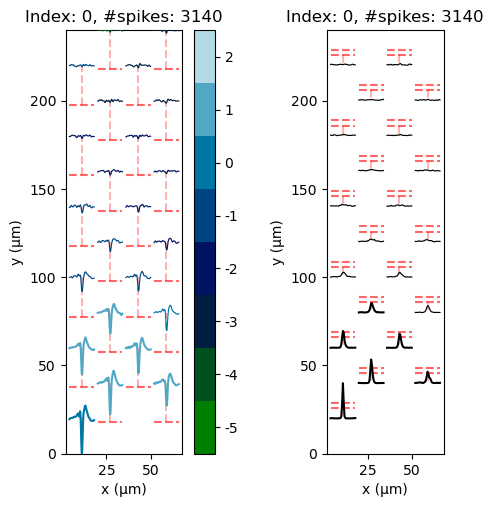

In [44]:
# cluster = root_elec_to_clusters[0][-1]
cluster = test
F.plot_elec_probs(cluster)
plt.show()

# plt.hist(cluster.every_elec_prob[0, :])
# plt.show()

Max root dist: 0.00
Inner overlap: 5
Loose overlap: 5, 1.00
Latency diff: 0.12
Amp diff : 0.02
2Z-score: 0.04


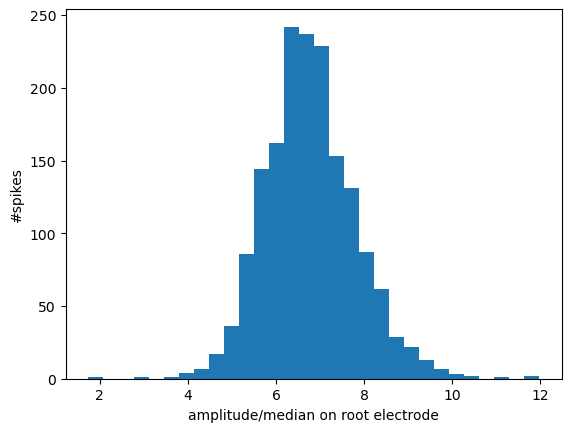

In [140]:
## Examine merge scores of seq pair
# cluster_i = trained_sequences[8]
# cluster_j = trained_sequences[9]

cluster_i = rt
cluster_j = gt_only_cluster

# F.plot_elec_probs(cluster_i)
# plt.show()
# F.plot_elec_probs(cluster_j)
# plt.show()

# amp_kwargs, prob_kwargs = F.plot_elec_probs(cluster_j)
# plt.show()
# F.plot_elec_probs(cluster_i, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
# plt.show()

max_dist = 0
for root_i in cluster_i.root_elecs:
    for root_j in cluster_j.root_elecs:
        max_dist = max(max_dist, F.calc_elec_dist(root_i, root_j))
print(f"Max root dist: {max_dist:.2f}")

total_loose = len(set(cluster_i.loose_elecs).union(cluster_j.loose_elecs))
num_loose_overlaps = len(set(cluster_i.loose_elecs).intersection(cluster_j.loose_elecs))
num_inner_loose_overlaps = len(set(cluster_i.inner_loose_elecs).intersection(cluster_j.inner_loose_elecs))
print(f"Inner overlap: {num_inner_loose_overlaps}")
print(f"Loose overlap: {num_loose_overlaps}, {num_loose_overlaps / total_loose:.2f}")

i_comp_elecs = cluster_i.comp_elecs
i_comp_elecs_set = set(i_comp_elecs)
j_comp_elecs = cluster_j.comp_elecs
comp_elecs = i_comp_elecs + [elec for elec in j_comp_elecs if elec not in i_comp_elecs_set]  # Prevents counting an elec more than once

# Get elec probs
i_elec_probs = cluster_i.all_elec_probs[comp_elecs]
j_elec_probs = cluster_j.all_elec_probs[comp_elecs]

# Compare latencies
i_latencies = cluster_i.all_latencies[comp_elecs][1:]
j_latencies = cluster_j.all_latencies[comp_elecs][1:] - cluster_j.all_latencies[comp_elecs[0]]  # Relative to same electrode as cluster_i
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=True)
latency_diff = np.abs(i_latencies - j_latencies)
latency_diff = np.clip(latency_diff, a_min=None, a_max=F.CLIP_LATENCY_DIFF)
latency_diff = np.sum(latency_diff * elec_weights)
print(f"Latency diff: {latency_diff:.2f}")

i_amp_medians = cluster_i.all_amp_medians[comp_elecs]
j_amp_medians = cluster_j.all_amp_medians[comp_elecs]                
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=False)
amp_median_div = (i_amp_medians + j_amp_medians) / 2
amp_median_diff = np.abs((i_amp_medians - j_amp_medians)) / amp_median_div
amp_median_diff = np.clip(amp_median_diff, a_min=None, a_max=F.CLIP_AMP_MEDIAN_DIFF)
amp_median_diff = np.sum(amp_median_diff * elec_weights)
print(f"Amp diff : {amp_median_diff:.2f}")

for root_elec in set(cluster_i.root_elecs + cluster_j.root_elecs):
    root_amps_i = cluster_i.every_amp_median[root_elec, :] # get_amp_medians(cluster_i, root_elec=root_elec)
    root_amps_j = cluster_j.every_amp_median[root_elec, :] # get_amp_medians(cluster_j, root_elec=root_elec)
    # dip, pval = diptest(np.concatenate([root_amps_i, root_amps_j]))
    # print(f"Elec {root_elec} p-val: {pval:.2f}")
    
    mean_i = cluster_i.all_amp_medians[root_elec]
    std_i = cluster_i.root_to_amp_median_std[root_elec] if root_elec in cluster_i.root_elecs else np.std(cluster_i.every_amp_median[root_elec], ddof=1)
    mean_j = cluster_j.all_amp_medians[root_elec]
    std_j = cluster_j.root_to_amp_median_std[root_elec] if root_elec in cluster_j.root_elecs else np.std(cluster_j.every_amp_median[root_elec], ddof=1)
    mean_diff = np.abs(mean_i - mean_j)
    two_z_score = max(mean_diff/std_i, mean_diff/std_j)
    print(f"2Z-score: {two_z_score:.2f}")
    
    plt.hist(np.concatenate([root_amps_i, root_amps_j]), bins=30)
    plt.ylabel("#spikes")
    plt.xlabel("amplitude/median on root electrode")
    plt.show()

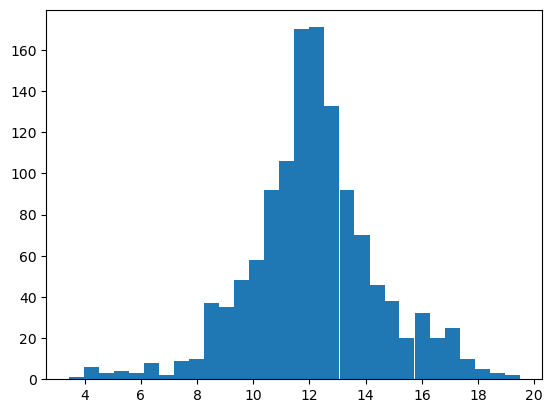

2

In [107]:
len(F.merge_coc_clusters(deepcopy([trained_sequences[0], trained_sequences[2]])))

## Testing ground-truth

In [16]:
merged_sequences = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/230113/merged_sequences.pickle")
merged_sequences = sorted(merged_sequences, key=lambda seq: list(ELEC_LOCS[seq.root_elec]))
for idx, seq in enumerate(merged_sequences):
    seq.idx = idx

In [50]:
len([seq for seq in merged_sequences if len(seq.spike_train) > 15])

376

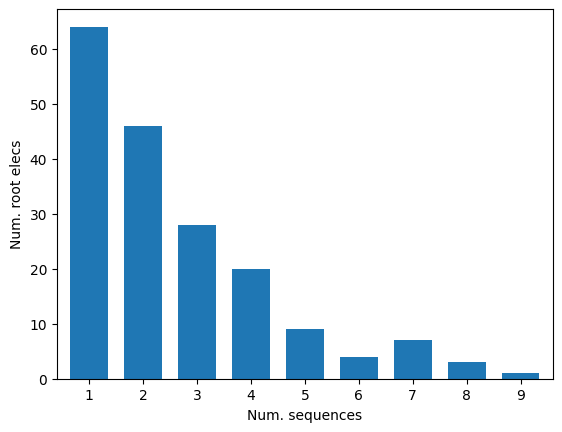

#elecs >= 4 seqs: 231


In [48]:
counts = {}
for seq in merged_sequences:
    if seq.root_elec not in counts:
        counts[seq.root_elec] = 1
    else:
        counts[seq.root_elec] += 1
        
from src import plot
counts_array = np.array(list(counts.values()))
plot.bar(counts_array)
plt.xlabel("Num. sequences")
plt.ylabel("Num. root elecs")
plt.show()
print("#elecs >= 4 seqs:", np.sum(counts_array[counts_array >= 4]))

In [ ]:
counts = {}
for seq in merged_sequences:
    if seq.root_elec not in counts:
        counts[seq.root_elec] = [seq]
    else:
        counts[seq.root_elec].append(seq)
for elec, seqs in counts.items():
    if len(seqs) >= 4:
        for seq in seqs:
            F.plot_elec_probs(seq, use_filt=False)
            plt.show()

In [161]:
## Examine merge scores of seq pair
cluster_i = trained_sequences[4]
cluster_j = trained_sequences[5]

print(f"Seqs {cluster_i.idx} and {cluster_j.idx}")

total_loose = len(set(cluster_i.loose_elecs).union(cluster_j.loose_elecs))
num_loose_overlaps = len(set(cluster_i.loose_elecs).intersection(cluster_j.loose_elecs))
print(f"Elec overlap: {num_loose_overlaps / total_loose:.2f}")

i_comp_elecs = cluster_i.comp_elecs
i_comp_elecs_set = set(i_comp_elecs)
j_comp_elecs = cluster_j.comp_elecs
comp_elecs = i_comp_elecs + [elec for elec in j_comp_elecs if elec not in i_comp_elecs_set]  # Prevents counting an elec more than once

# Get elec probs
i_elec_probs = cluster_i.all_elec_probs[comp_elecs]
j_elec_probs = cluster_j.all_elec_probs[comp_elecs]

# Compare latencies
i_latencies = cluster_i.all_latencies[comp_elecs][1:]
j_latencies = cluster_j.all_latencies[comp_elecs][1:] - cluster_i.all_latencies[comp_elecs[0]]
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=True)
latency_diff = np.abs(i_latencies - j_latencies)
latency_diff = np.clip(latency_diff, a_min=None, a_max=F.CLIP_LATENCY_DIFF)
latency_diff = np.sum(latency_diff * elec_weights)
print(f"Latency diff: {latency_diff:.2f}")

i_amp_medians = cluster_i.all_amp_medians[comp_elecs]
j_amp_medians = cluster_j.all_amp_medians[comp_elecs]                
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=False)
amp_median_div = (i_amp_medians + j_amp_medians) / 2
amp_median_diff = np.abs((i_amp_medians - j_amp_medians)) / amp_median_div
amp_median_diff = np.clip(amp_median_diff, a_min=None, a_max=F.CLIP_AMP_MEDIAN_DIFF)
amp_median_diff = np.sum(amp_median_diff * elec_weights)
print(f"Amp diff : {amp_median_diff:.2f}")

for root_elec in set(cluster_i.root_elecs + cluster_j.root_elecs):
    root_amps_i = cluster_i.every_amp_median[root_elec, :] # get_amp_medians(cluster_i, root_elec=root_elec)
    root_amps_j = cluster_j.every_amp_median[root_elec, :] # get_amp_medians(cluster_j, root_elec=root_elec)
    dip, pval = diptest(np.concatenate([root_amps_i, root_amps_j]))
    print(f"Elec {root_elec} p-val: {pval:.2f}")

Seqs 4 and 5
Elec overlap: 1.00
Latency diff: 0.78
Amp diff : 0.08
Elec 2 p-val: 0.00


In [133]:
F.calc_elec_dist(cluster_i.root_elec, cluster_j.root_elec)

101.27191120937731

### Ground truth

In [54]:
gt_sequences = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/ground_truth_sequences.pickle")
gt_sequences = sorted(gt_sequences, key=lambda seq: list(ELEC_LOCS[seq.root_elec]))
elec_to_gt_seq = {}
for idx, seq in enumerate(gt_sequences):
    seq.idx = idx
    if seq.root_elec not in elec_to_gt_seq:
        elec_to_gt_seq[seq.root_elec] = [seq]
    else:
        elec_to_gt_seq[seq.root_elec].append(seq)

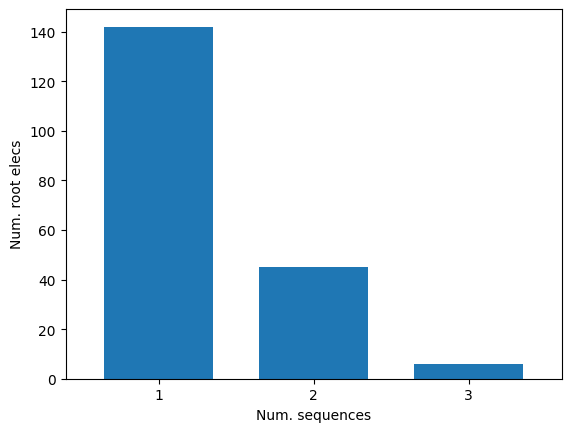

In [80]:
counts = {}
for seq in gt_sequences:
    if seq.root_elec not in counts:
        counts[seq.root_elec] = 1
    else:
        counts[seq.root_elec] += 1
        
from src import plot
plot.bar(list(counts.values()))
plt.xlabel("Num. sequences")
plt.ylabel("Num. root elecs")
plt.show()

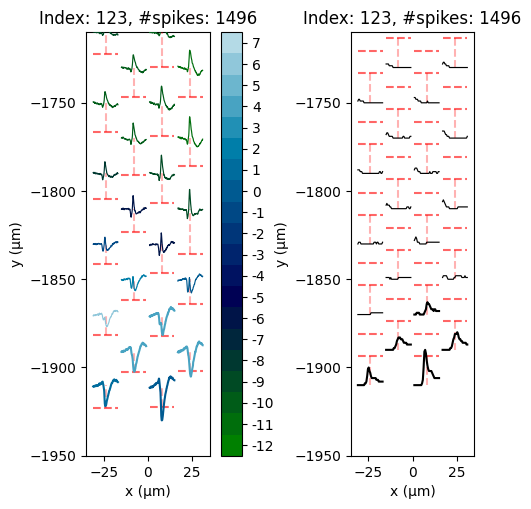

In [66]:
# for seq in gt_sequences[5:25]:    
root_elec = 0
for elec in [root_elec] + ALL_CLOSEST_ELECS[root_elec]:
    if F.calc_elec_dist(root_elec, elec) > F.INNER_RADIUS:
        break
    
    if elec in elec_to_gt_seq:
        for seq in elec_to_gt_seq[elec]:
            F.plot_elec_probs(seq, use_filt=False)
            plt.show()

In [65]:
# for seq in tqdm(gt_sequences):
#     F.plot_elec_probs(seq, use_filt=False)
#     plt.savefig(f"/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/ground_truth_sequences/footprints/{seq.idx}.jpg", format="jpg")
#     plt.close()

100%|██████████| 250/250 [03:09<00:00,  1.32it/s]


## Full run - DL model

In [9]:
stopwatch.start()
F.save_traces_si(SCALED_TRACES_PATH, start_ms=TRAINING_MS[0], end_ms=TESTING_MS[1])
stopwatch.stop()

Alllocating memory for traces ...
Extracting traces ...


100%|██████████| 384/384 [00:41<00:00,  9.29it/s]


In [10]:
from src.run_alg.model import ModelSpikeSorter
stopwatch.start()
model = ModelSpikeSorter.load(MODEL_PATH)
model.compile(NUM_ELECS, MODEL_PATH)
stopwatch.stop()

In [11]:
stopwatch.start()
F.run_dl_model(MODEL_PATH, SCALED_TRACES_PATH, MODEL_TRACES_PATH, MODEL_OUTPUTS_PATH)
stopwatch.stop()

Loading DL model ...
Allocating memory to save model traces and outputs ...


/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Inference scaling: 0.7365530126109295
Running model ...


100%|██████████| 106666/106666 [03:25<00:00, 518.62it/s]


In [12]:
stopwatch.start()
F.NUM_ELECS = NUM_ELECS
F.SAMP_FREQ = SAMP_FREQ
F.FRONT_BUFFER = FRONT_BUFFER
F.STRINGENT_THRESH = STRINGENT_THRESH
F.STRINGENT_THRESH_LOGIT = STRINGENT_THRESH_LOGIT
F.extract_crossings(MODEL_OUTPUTS_PATH, ALL_CROSSINGS_PATH, ELEC_CROSSINGS_IND_PATH)
stopwatch.stop()

100%|██████████| 19199/19199 [01:36<00:00, 198.12it/s]


In [13]:
print(f"Time to run DL model: {stopwatch.duration} seconds")

Time to run DL model: 395.11705231666565 seconds


## Full run - sequences

In [16]:
stopwatch.duration

397.90455865859985

In [17]:
stopwatch.start()
ROOT_PATH = Path("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/240327")
ROOT_PATH.mkdir(exist_ok=True, parents=True)
MIN_SPIKES = max(10, 0.05 * (TRAINING_MS[1] - TRAINING_MS[0]) / 1000)

all_clusters = F.form_all_clusters(TRACES_TRAINING_MS)
all_clusters_reassigned = F.reassign_spikes(all_clusters, TRACES_TRAINING_MS, MIN_SPIKES)
intra_merged_clusters = F.intra_merge(all_clusters_reassigned) 
trained_sequences = F.inter_merge(intra_merged_clusters, MIN_SPIKES)

stopwatch.stop()
print(f"Time to detect sequences: {stopwatch.duration} seconds")

# Save data
utils.pickle_dump(all_clusters, ROOT_PATH / "all_clusters.pickle")
utils.pickle_dump(all_clusters_reassigned, ROOT_PATH / "all_clusters_reassigned.pickle")
utils.pickle_dump(trained_sequences, ROOT_PATH / "trained_sequences.pickle")

100%|██████████| 384/384 [01:57<00:00,  3.26it/s]


725 sequences before merging


100%|██████████| 114/114 [00:02<00:00, 39.63it/s]


130 sequences after first merging

Merged 52 with 31
Latency diff: 0.44. Amp median diff: 0.06
Amp dist p-value 0.4790
#spikes:
Merge base: 405, Add: 873, Overlaps: 1
After merging: 1277

Merged 41 with 96
Latency diff: 0.60. Amp median diff: 0.09
Amp dist p-value 1.8945
#spikes:
Merge base: 520, Add: 2013, Overlaps: 2
After merging: 2530

Merged 92 with 88
Latency diff: 0.50. Amp median diff: 0.12
Amp dist p-value 0.4160
#spikes:
Merge base: 773, Add: 119, Overlaps: 0
After merging: 892

Merged 66 with 59
Latency diff: 0.41. Amp median diff: 0.19
Amp dist p-value 0.0504
#spikes:
Merge base: 1502, Add: 620, Overlaps: 0
After merging: 2122

Merged 0 with 5
Latency diff: 0.99. Amp median diff: 0.12
Amp dist p-value 0.7842
#spikes:
Merge base: 514, Add: 1330, Overlaps: 2
After merging: 1835

Merged 95 with 45
Latency diff: 0.90. Amp median diff: 0.17
Amp dist p-value 0.4331
#spikes:
Merge base: 1028, Add: 887, Overlaps: 5
After merging: 1896

Merged 104 with 39
Latency diff: 1.10. Amp med

### Run each part separately

In [36]:
ROOT_PATH = Path("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/240319_delete_me")
ROOT_PATH.mkdir(exist_ok=True, parents=True)

MIN_SPIKES = max(10, 0.05 * (TRAINING_MS[1] - TRAINING_MS[0]) / 1000)

In [37]:
all_clusters = F.form_all_clusters(TRACES_TRAINING_MS)  # 707 sequences when run 240319

100%|██████████| 384/384 [02:18<00:00,  2.77it/s]


707 sequences before merging


In [24]:
utils.pickle_dump(all_clusters, ROOT_PATH / "all_clusters.pickle")

In [25]:
all_clusters = utils.pickle_load(ROOT_PATH / "all_clusters.pickle")

In [26]:
all_clusters_reassigned = F.reassign_spikes(all_clusters, TRACES_TRAINING_MS, MIN_SPIKES)

100%|██████████| 692/692 [01:49<00:00,  6.32it/s]


In [27]:
utils.pickle_dump(all_clusters_reassigned, ROOT_PATH / "all_clusters_reassigned.pickle")

In [28]:
all_clusters_reassigned = utils.pickle_load(ROOT_PATH / "all_clusters_reassigned.pickle")
# region Test merging
# root_elec_to_clusters = {}
# for cluster in utils.pickle_load(ROOT_PATH / "all_clusters_reassigned.pickle"):
#     if cluster.root_elec not in root_elec_to_clusters:
#         root_elec_to_clusters[cluster.root_elec] = [cluster]
#     else:
#         root_elec_to_clusters[cluster.root_elec].append(cluster)
# tasks = list(root_elec_to_clusters.values())

# F.merge_coc_clusters(root_elec_to_clusters[1], verbose=True)

# for clust in root_elec_to_clusters[1]:
#     F.plot_elec_probs(clust)
#     plt.show()
# endregion

In [29]:
# Merge clusters with the same root electrode
intra_merged_clusters = F.intra_merge(all_clusters_reassigned) 

 93%|█████████▎| 104/112 [00:01<00:00, 66.42it/s]

100%|██████████| 112/112 [00:02<00:00, 42.13it/s]


130 sequences after first merging


In [30]:
trained_sequences = F.inter_merge(intra_merged_clusters, MIN_SPIKES)


Merged 95 with 92
Latency diff: 0.24. Amp median diff: 0.06
Amp dist p-value 0.3462
#spikes:
Merge base: 769, Add: 271, Overlaps: 0
After merging: 1040

Merged 52 with 38
Latency diff: 0.43. Amp median diff: 0.06
Amp dist p-value 0.5347
#spikes:
Merge base: 407, Add: 865, Overlaps: 1
After merging: 1271

Merged 39 with 104
Latency diff: 0.59. Amp median diff: 0.09
Amp dist p-value 1.8887
#spikes:
Merge base: 520, Add: 2013, Overlaps: 2
After merging: 2530

Merged 68 with 62
Latency diff: 0.42. Amp median diff: 0.20
Amp dist p-value 0.2966
#spikes:
Merge base: 1602, Add: 467, Overlaps: 0
After merging: 2069

Merged 0 with 6
Latency diff: 1.00. Amp median diff: 0.12
Amp dist p-value 0.7778
#spikes:
Merge base: 516, Add: 1331, Overlaps: 2
After merging: 1838

Merged 96 with 48
Latency diff: 0.89. Amp median diff: 0.18
Amp dist p-value 0.3972
#spikes:
Merge base: 937, Add: 921, Overlaps: 2
After merging: 1836

Merged 103 with 36
Latency diff: 1.11. Amp median diff: 0.22
Amp dist p-value 2

In [31]:
utils.pickle_dump(trained_sequences, ROOT_PATH / "trained_sequences.pickle")

In [34]:
trained_sequences = utils.pickle_load(ROOT_PATH / "trained_sequences.pickle")

### Assign spikes in testing region

In [18]:
F.assign_spikes_torch(trained_sequences, TESTING_MS) 
torch.cuda.empty_cache()

100%|██████████| 59990/59990 [02:02<00:00, 487.93it/s]


In [19]:
utils.pickle_dump(trained_sequences, ROOT_PATH / "tested_sequences.pickle")

In [20]:
tested_sequences = utils.pickle_load(ROOT_PATH / "tested_sequences.pickle")

In [ ]:
# # Isi violation sanity check
# test = []
# for i, clust in enumerate(tested_sequences):
#     isis = np.diff(clust.spike_train)
#     viols = isis <= 1.5
#     # print(i, np.sum(viols)/len(clust.spike_train)*100)
#     test.append(np.sum(viols)/len(clust.spike_train)*100)
# plt.hist(test, bins=30)
# plt.show()

100%|██████████| 59990/59990 [03:35<00:00, 277.94it/s]


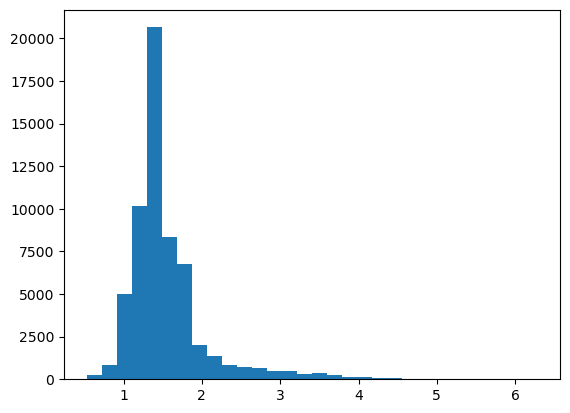

1.5431384338437175


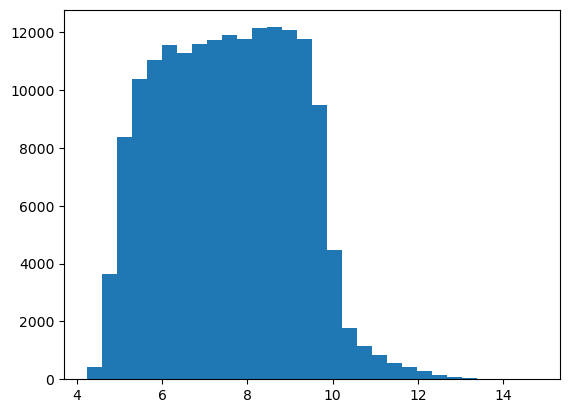

7.5676984957481785


In [33]:
# Measure computation times (need to go in code and uncommment where there are break points in assign_spikes_torch)
F.MODEL_PATH = MODEL_PATH
F.SCALED_TRACES_PATH = SCALED_TRACES_PATH
sorting_computation_times, sorting_delays = F.measure_speed_assign_spikes_torch(trained_sequences, TESTING_MS) 
torch.cuda.empty_cache()
plt.hist(sorting_computation_times, bins=30) 
plt.show()
print(np.mean(sorting_computation_times))

plt.hist(sorting_delays, bins=30) 
plt.show()
print(np.mean(sorting_delays))

In [34]:
np.save(ROOT_PATH / "sorting_computation_times.npy", sorting_computation_times)
np.save(ROOT_PATH / "sorting_delays.npy", sorting_delays)

#### Manually check tested_sequences

In [ ]:
# Plot sequences
use_formation_spike_train = False
use_filt = False  # If True, amp in footprint may not match histogram (histogram does not use filtered traces)

for seq in trained_sequences[10:20]:
    F.plot_elec_probs(seq, idx=seq.idx, use_formation_spike_train=use_formation_spike_train, use_filt=use_filt)
    plt.show()
            
    # amp_medians = seq.every_amp_median[seq.root_elec, :]
    amp_medians = F.get_amp_medians(seq).flatten()
    plt.hist(amp_medians, bins=30)
    plt.show()
    print(np.mean(amp_medians))
    
    print(f"dip p-val: {diptest(amp_medians)[1]:.3f}")

In [ ]:
# Split amp dist
SPLIT_AMP = 7
    
spikes1 = []
spikes2 = []
for time, amp in zip(seq.spike_train, F.get_amp_medians(seq)):
    if amp < SPLIT_AMP:
        spikes1.append(time)
    else:
        spikes2.append(time)
F.plot_spikes(spikes1, seq.root_elec)
plt.show()
F.plot_spikes(spikes2, seq.root_elec)
plt.show()

In [ ]:
tested_sequences = [seq for seq in tested_sequences if len(seq.spike_train) > 0]
F.save_sequences_plots(tested_sequences, ROOT_PATH / "footprints")

In [28]:
prop_signal = F.clusters_to_sorter(tested_sequences)
prop_signal.recording = None
utils.pickle_dump(prop_signal, ROOT_PATH / "prop_signal.pickle")

## Compare to ground truth

### Setup

In [11]:
from spikeinterface.extractors import NwbSortingExtractor

%autoreload 2
from src.comparison import Comparison, DummySorter

In [12]:
ROOT_PATH = Path("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/240327")
tested_sequences = utils.pickle_load(ROOT_PATH / "tested_sequences.pickle")

In [13]:
sorter = NwbSortingExtractor("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/sub-MEAREC-250neuron-Neuropixels_ecephys.nwb")

gt_spike_times = []
for uid in sorter.get_unit_ids():
    spike_train = sorter.get_unit_spike_train(uid)
    spike_train = spike_train / sorter.get_sampling_frequency() * 1000
    spike_train = spike_train[(spike_train >= TESTING_MS[0]) & (spike_train <= TESTING_MS[1])]
    gt_spike_times.append(np.sort(spike_train))
    
# gt_spike_times = []
# for seq in utils.pickle_load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/ground_truth_sequences.pickle"):
#     spike_train = seq.formation_spike_train
#     gt_spike_times.append(np.sort(spike_train[spike_train >= PRE_MEDIAN_FRAMES/SAMP_FREQ]))

# precisions, recalls = [], []
# performances = []
# for detected, gt in zip(detected_spike_times, gt_spike_times):
#     num_matches = Comparison.count_matching_events(detected, gt)
#     if len(detected) > 0:
#         precision = num_matches/len(detected) * 100
#         precisions.append(precision)
#     else:
#         precision = 0
#     recall = num_matches / len(gt) *100
#     recalls.append(recall)
#     performances.append(recall + precision)
# performance = np.median(performances)
# print(performance)
    
# plt.title("Precisions")
# plt.hist(precisions, bins=30)
# plt.ylabel("Num. units")
# plt.xlabel("%")
# plt.show()

# plt.title("Recalls")
# plt.hist(recalls, bins=30)
# plt.ylabel("Num. units")
# plt.xlabel("%")
# plt.show()

prop_signal = DummySorter([seq.spike_train for seq in tested_sequences], name="RT-Sort")
kilosort = DummySorter(gt_spike_times, name="Ground-Truth")

### Create kilosort units
Needed for other types of analysis

In [ ]:
# kilosort = get_experts_kilosort(testing_ms=TESTING_MS)
# kilosort = get_experts_kilosort(testing_ms=TRAINING_MS)

# Create all_ks_units with self.templates and self.chan set --> Don't run this if already ran before
all_ks_units = []

def job(idx):
    unit = Unit(idx, all_ks_spike_times[idx], -1, RECORDING)
    templates = unit.get_templates()
    unit.templates = templates
    unit.recording = None
    unit.chan = np.argmin(np.min(templates, axis=1))
    unit.root_elecs = [unit.chan]
    return unit

all_ks_spike_times = kilosort.get_spike_times()
with Pool(processes=20) as pool:
    tasks = range(len(all_ks_spike_times))
    for unit in tqdm(pool.imap(job, tasks), total=len(tasks)):
        unit.recording = RECORDING
        all_ks_units.append(unit)
        
chan_to_ks_units = {}
for unit in all_ks_units:
    if unit.chan not in chan_to_ks_units:
        chan_to_ks_units[unit.chan] = [unit]
    else:
        chan_to_ks_units[unit.chan].append(unit)

In [ ]:
# chan_to_prop_units = {}
# for unit in final_sequences:
#     for chan in unit.root_elecs:
#         if chan not in chan_to_prop_units:
#             chan_to_prop_units[chan] = [unit]
#         else:
#             chan_to_prop_units[chan].append(unit)

### Start comparing

In [14]:
prop_signal = F.clusters_to_sorter(tested_sequences)

In [ ]:
Comparison.count_all_overlaps(prop_signal.get_spike_times(), kilosort.get_spike_times())

In [ ]:
comp_1_5 = Comparison(prop_signal, kilosort, score_formula=1.5, delta_time=0.4)
comp_1_5.summary()
# comp_1_5.plot_line_comps()

comp_1 = Comparison(prop_signal, kilosort, score_formula=1, delta_time=0.4)
comp_1.summary()
# comp_1.plot_line_comps()

comp_2 = Comparison(prop_signal, kilosort, score_formula=2, delta_time=0.4)
comp_2.summary()
# comp_2.plot_line_comps()

In [25]:
# Save data for RT-Sort manuscript
save_root = ROOT_PATH / "overlap_scores"

# Save scores for RT-Sort units
rt_path = save_root / "rt_sort_units"
rt_path.mkdir(exist_ok=True, parents=True)
gt_path = save_root / "ground_truth_units"
gt_path.mkdir(exist_ok=True, parents=True)

rt, gt = comp_1_5.get_max_agreement_scores()
np.save(rt_path / "spikeinterface_formula.npy", rt)
np.save(gt_path / "spikeinterface_formula.npy", gt)

rt, gt = comp_1.get_max_agreement_scores()
np.save(rt_path / "precision.npy", rt)
np.save(gt_path / "precision.npy", gt)

rt, gt = comp_2.get_max_agreement_scores()
np.save(rt_path / "recall.npy", rt)
np.save(gt_path / "recall.npy", gt)

In [ ]:
Comparison.plot_comp_1_2_scatter(comp_1, comp_2)

### Save unrealistic-looking ground-truth units with low overlap scores for RT-Sort units
For RT-Sort manuscript

In si_rec13.py, function plot_elec_probs, set SI_SIM_REC to True

Need to go into sorters/base.py, Unit.plot and uncomment parameters to use spikeinterface simulated recording for proper plotting
- xlim = (-35, 35)  # for SI ground truth rec
- ymin = max(-1950, loc_center[1] - window_half_size)  # SI simulated ground truth
- window_half_size = 110  # for SI ground truth rec
- axis.set_ylim(ymin-12, ymax)  # SI simulated ground truth weird-looking units have such low SNR that need extra space at bottom for 5SNR line

In [135]:
FIG_SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/240327/unrealistic_ground_truth_units")
FORMAT = "svg"

In [14]:
comp_1_5 = Comparison(prop_signal, kilosort, score_formula=1.5, delta_time=0.4)
rt_scores, gt_scores = comp_1_5.get_max_agreement_scores()

In [ ]:
# Find units
for idx in np.argsort(gt_scores)[0:10]:
    spike_train = gt_spike_times[idx]
    F.plot_spikes(spike_train, -1, idx=idx)
    plt.show()

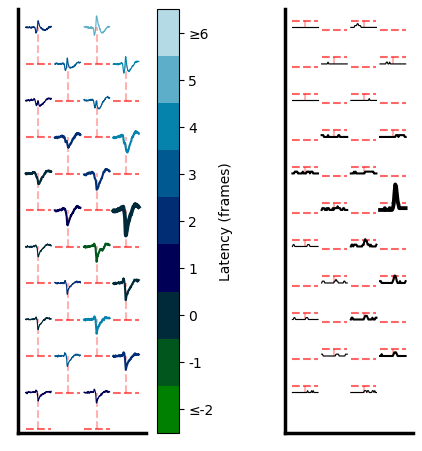

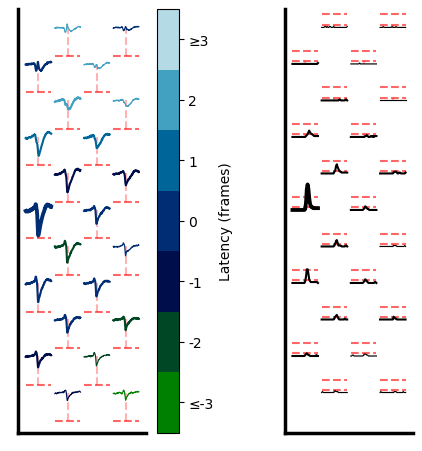

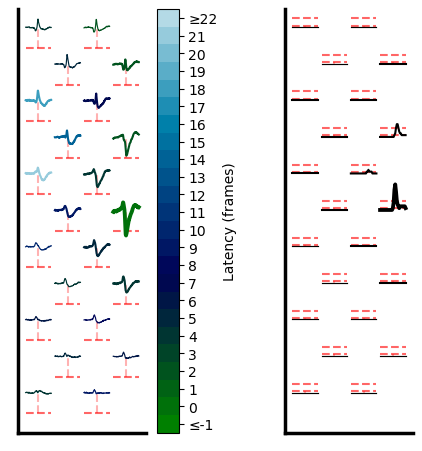

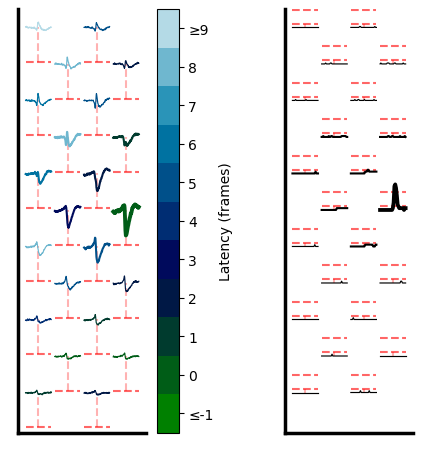

In [139]:
UNIT_IND = [186, 153, 145, 190]
##
rt_spike_times = prop_signal.get_spike_times()
for idx in UNIT_IND:
    save_root = FIG_SAVE_ROOT / str(idx)
    save_root.mkdir(exist_ok=True, parents=True)
    
    spike_train = gt_spike_times[idx]
    F.plot_spikes(spike_train, -1, idx=idx, debug=False)
    plt.savefig(save_root / f"5_10min_footprint.{FORMAT}", format=FORMAT)
    plt.show()
    
    rt_idx = np.argmax(comp_1_5.agreement_scores[:, idx])
    si_overlap_score = comp_1_5.agreement_scores[rt_idx, idx]
    assert si_overlap_score == gt_scores[idx]  # Sanity check that getting correct RT-Sort unit
    num_rt = len(rt_spike_times[rt_idx])
    num_gt = len(gt_spike_times[idx])
    num_tp = Comparison.count_matching_events(rt_spike_times[rt_idx], gt_spike_times[idx])
    assert num_tp / (num_rt + num_gt - num_tp)  # Sanity check that getting correct num_tp
    
    si_overlap_score *= 100
    precision = num_tp / num_rt * 100
    recall = num_tp / num_gt * 100
    
    save_text = f"Spikeinterface overlap score: {si_overlap_score:.1f}%\nPrecision: {precision:.1f}%\nRecall: {recall:.1f}%"
    with open(save_root / "rt_sort_performance.txt", "w") as file:
        file.write(save_text)


### Lost to time
Not sure what the code in this section was used for, but keeping it in case of needing it in the future

In [57]:
rt_recalls = np.max(comp_2.agreement_scores, axis=1)
seq_ind = np.argsort(rt_recalls)

In [ ]:
for IDX in seq_ind[:15]:
    print("-"*50)
    seq = tested_sequences[IDX]
    if len(seq.spike_train) == 0:
        continue
    print(rt_recalls[IDX])
    F.plot_elec_probs(seq)
    plt.show()
    
    gt_idx = np.argmax(comp_2.agreement_scores[IDX])
    spike_train = kilosort.get_spike_times()[gt_idx]
    F.plot_spikes(spike_train, seq.root_elec)
    plt.show()

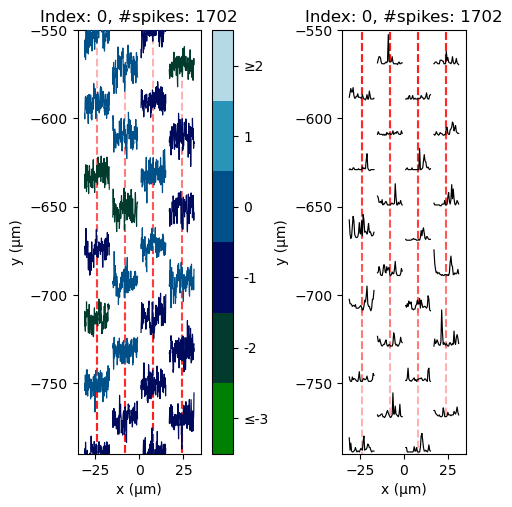

In [60]:
gt_idx = np.argmax(comp_2.agreement_scores[IDX])
spike_train = kilosort.get_spike_times()[gt_idx]
F.plot_spikes(spike_train, seq.root_elec)
plt.show()

In [55]:
def job(task):
    unit_idx, save_dir = task

    chans_rms = np.full(NUM_ELECS, 1)
    unit_data = sorter[unit_idx]

    fig, axes = plt.subplots(ncols=3, figsize=(2.3*3, 5.5))
    m_ax, r_ax, o_ax = axes

    rt_unit=Unit(unit_data['idx'], [spike['time'] for spike in unit_data['matching_spikes']] + [spike['time'] for spike in unit_data['rt_sort_only_spikes']], unit_data["root_elec"], RECORDING)
    _, wf_widths, _ = F.plot_elec_probs(rt_unit, return_wf_data=True)

    m_unit=Unit(unit_data['idx'], [spike['time'] for spike in unit_data['matching_spikes']], unit_data["root_elec"], RECORDING)
    m_temps, _, m_wf_colors = F.plot_elec_probs(m_unit, return_wf_data=True)
    r_unit=Unit(unit_data['idx'], [spike['time'] for spike in unit_data['rt_sort_only_spikes']], unit_data["root_elec"], RECORDING)
    r_temps, _, r_wf_colors = F.plot_elec_probs(r_unit, return_wf_data=True)
    o_unit=Unit(unit_data['idx'], [spike['time'] for spike in unit_data['other_sorter_only_spikes']], unit_data["root_elec"], RECORDING)
    o_temps, _, o_wf_colors = F.plot_elec_probs(o_unit, return_wf_data=True)
    
    # Determine color bar limits
    color_elecs = unit_data['loose_elecs']  # Elecs used to determine color bar limits
    min_c = np.inf
    max_c = -np.inf
    for colors in (m_wf_colors, r_wf_colors, o_wf_colors):
        if np.all(np.isnan(colors)):
            continue
        colors = [colors[elec] for elec in color_elecs]
        min_c = min(min_c, round(np.floor(np.min(colors))) - 1)
        max_c = max(max_c, round(np.ceil(np.max(colors))) + 1)
    
    amp_kwargs = m_unit.plot(axis=m_ax, wf=m_temps, wf_widths=wf_widths, wf_colors=m_wf_colors, fig=fig, mea=False,
                             chans_rms=chans_rms, min_c=min_c, max_c=max_c,
                             colorbar_location="left", use_colorbar_label=True)
    r_unit.plot(axis=r_ax, wf=r_temps, wf_widths=wf_widths, wf_colors=r_wf_colors, fig=None, mea=False,
                colorbar_location="left", use_colorbar_label=True,
                **amp_kwargs)
    o_unit.plot(axis=o_ax, wf=o_temps, wf_widths=wf_widths, wf_colors=o_wf_colors, fig=None, mea=False,
                colorbar_location="left", use_colorbar_label=True,
                **amp_kwargs)

    m_ax.set_title("Matching")
    r_ax.set_title("RT-Sort only")
    o_ax.set_title(f"{sorter_name} only")
    
    for ax in axes:
        ax.set_xlabel("")
        ax.set_xticks([])
        ax.set_ylabel("")
        ax.set_yticks([])

    plt.show()
    # plt.savefig(save_dir / f"{unit_data['idx']}.svg", format="svg")
    # plt.close()
    
# # Testing 
kilosort = np.load(ROOT_PATH/"kilosort2.npy", allow_pickle=True)
unit_idx = [unit["idx"] for unit in kilosort].index(0)

SORTER = np.load(SORTER_PATHS[0], allow_pickle=True)
SORTER_NAME = "Kilosort2"
job((2, None))
    
# np.seterr("ignore")  # RuntimeWarning: invalid value encountered in true_divide ret, rcount, out=ret, casting='unsafe', subok=False) # Mean of empty slice warning is when matching, RT-Sort only, or other only have no spikes
# for sorter_path, SORTER_NAME in zip(SORTER_PATHS, SORTER_NAMES):
#     print(SORTER_NAME)
#     SORTER = np.load(sorter_path, allow_pickle=True)
#     save_dir = SAVE_ROOT / sorter_path.name.split(".")[0]
#     save_dir.mkdir(parents=True, exist_ok=True)
#     tasks = [(unit_idx, save_dir) for unit_idx in range(len(SORTER))]
#     with Pool(processes=16) as pool:
#         for _ in tqdm(pool.imap_unordered(job, tasks), total=len(tasks)):
#             pass
# np.seterr('raise')

1

## Kilosort units as sequences
Test assigning spikes by treating kilosort units as sequences

In [9]:
SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230")

In [10]:
%autoreload 2
from src.comparison import Comparison
from src import plot
from src.sorters.base import Unit
from src.sorters.kilosort import get_experts_kilosort

In [12]:
kilosort = get_experts_kilosort(testing_ms=TRAINING_MS, overlap_time=0.1)

/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.2.0 because version 1.6.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.6.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/pynwb/ecephys.py:93: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match

Recording does not have scaled traces. Setting gain to 0.195


In [13]:
# Setup kilosort units as sequences --> need to find root elec (max-amp elec)

original_ks_sequences = []
original_ks_spike_times = kilosort.get_spike_times()
chan_to_ks_seqs = {}

def job(idx):    
    cluster = F.CocCluster(-1, -1, original_ks_spike_times[idx])
    
    all_waveforms = F.extract_waveforms(cluster)   
    templates = np.mean(all_waveforms, axis=0)
    root_elec = np.argmin(np.min(templates, axis=1))
    
    cluster.root_elec = root_elec
    cluster.root_elecs = [root_elec]
    # F.setup_cluster(cluster)
    
    return cluster

# with Pool(processes=20) as pool:
#     tasks = range(len(original_ks_spike_times))
#     for idx, cluster in tqdm(enumerate(pool.imap(job, tasks)), total=len(tasks)):
#         cluster.idx = idx
#         original_ks_sequences.append(cluster)
        
# for seq in chan_to_ks_seqs:
#     if seq.root_elec not in chan_to_ks_seqs:
#         chan_to_ks_seqs[seq.root_elec] = [seq]
#     else:
#         chan_to_ks_seqs[seq.root_elec].append(seq)

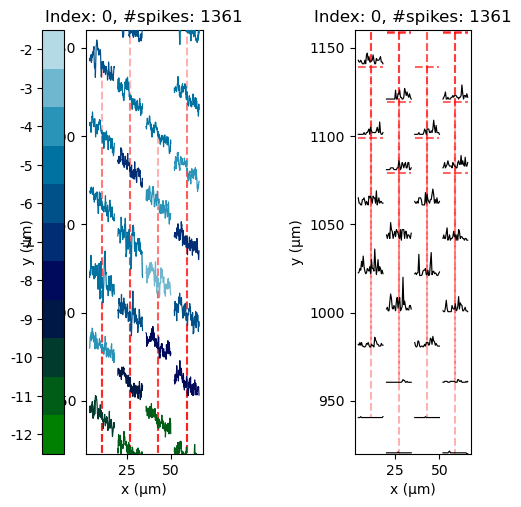

In [ ]:
unit = job(0)
F.plot_elec_probs(unit)
plt.show()

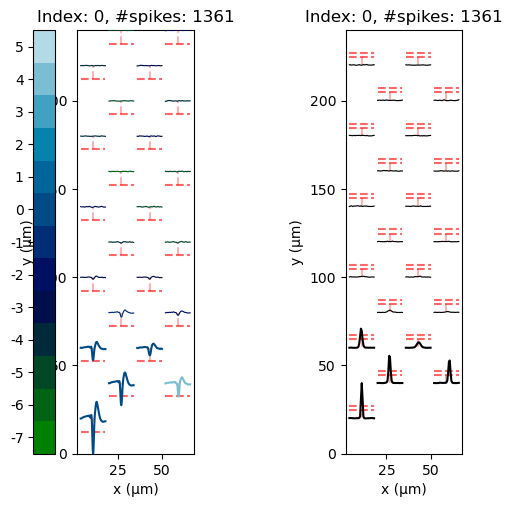

In [24]:
unit = job(0)
F.plot_elec_probs(unit)
plt.show()

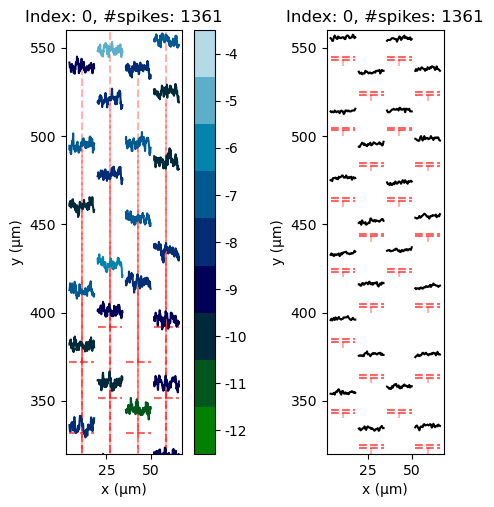

In [18]:
F.TRACES = np.load(SCALED_TRACES_PATH, mmap_mode="r")
F.OUTPUTS = F.TRACES
unit = job(0)
F.plot_elec_probs(unit)
plt.show()

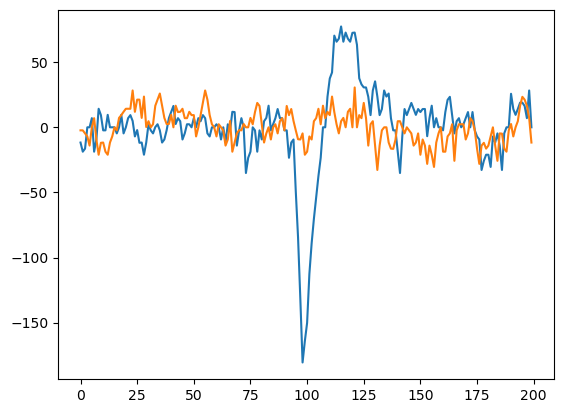

In [24]:
spike = unit.spike_train[2]
frame = round(spike * SAMP_FREQ)
trace = RECORDING.get_traces(start_frame=frame-100, end_frame=frame+100, 
                             channel_ids=[RECORDING.get_channel_ids()[0]], return_scaled=True).flatten().astype('float32')
plt.plot(trace)
plt.plot(F.TRACES[0, frame-100:frame+100])
plt.show()

In [ ]:
# viol_p = []
# for seq in original_ks_sequences:
#     spike_train = seq.spike_train
#     isis = np.diff(spike_train)
#     num_viols = np.sum(isis <= 1.5)
#     viol_p.append(num_viols / len(spike_train) * 100)
# plt.hist(viol_p, bins=60)
# plt.show()

In [13]:
# Called "all" but these are the sequences that can be detected by RT-Sort (at least 2 loose elecs)
all_ks_sequences = []
all_ks_spike_times = []

un_ks_sequences = []  # Sequences that cannot be detected by RT-Sort
for seq, times in zip(original_ks_sequences, original_ks_spike_times):
    if len(seq.loose_elecs) >= 2:
        all_ks_sequences.append(seq)
        all_ks_spike_times.append(times)
    else:
        un_ks_sequences.append(seq)
        
print(f"{len(original_ks_sequences)} kilosort units")
print(f"{len(all_ks_sequences)} detectable kilosort units (at least 2 loose elecs)")

226 kilosort units
211 detectable kilosort units (at least 2 loose elecs)


In [130]:
for seq in un_ks_sequences:
    F.plot_elec_probs(seq)
    # plt.savefig(f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230/footprints_undetectable/{seq.idx}.jpg", format="jpg")
    # plt.close()

In [15]:
F.assign_spikes(all_ks_sequences, TRAINING_MS,
                interelec=True, only_max_amps=False,
                verbose=True)

100%|██████████| 3909373/3909373 [24:15<00:00, 2685.31it/s]


In [132]:
for seq in all_ks_sequences:
    if len(seq.spike_train) == 0:
        seq._spike_train = seq.formation_spike_train
        F.plot_elec_probs(seq)
        seq._spike_train = []
        plt.savefig(f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230/footprints/no_spikes/{seq.idx}.jpg", format="jpg")
        plt.close()

In [16]:
utils.pickle_dump(all_ks_sequences, SAVE_ROOT / "all_ks_sequences.pickle")
prop_signal = F.clusters_to_sorter(all_ks_sequences)
prop_signal.recording = None
utils.pickle_dump(prop_signal, SAVE_ROOT / "ks_as_prop_signal.pickle")

In [21]:
# ks_as_prop_signal = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231219/ks_as_prop_signal.pickle")
# all_ks_sequences = []
# for unit in ks_as_prop_signal:
#     unit.root_elec = unit.chan
#     all_ks_sequences.append(unit)

In [111]:
# Naive way to check precision and recall (does not account for location of units when finding spike match)
all_prop_spikes = []
for seq in all_ks_sequences:
    all_prop_spikes.extend(seq.spike_train)
all_prop_spikes = np.sort(all_prop_spikes)

all_ks_spikes = []
for spike_train in all_ks_spike_times:
    all_ks_spikes.extend(spike_train)
all_ks_spikes = np.sort(all_ks_spikes)

matching_prop_times, unmatched_prop_times, unmatched_ks_times = Comparison.get_matching_events(all_prop_spikes, all_ks_spikes)

# num_matches = len(matching_prop_times)
# print(f"#matches: {num_matches}")
# print(f"#matches/#rt_sort: {num_matches/(len(unmatched_prop_times) + num_matches)*100:.1f}%")
# print(f"#matches/#kilosort: {num_matches/(len(unmatched_ks_times) + num_matches)*100:.1f}%")

tp = len(matching_prop_times)
fp = len(unmatched_prop_times)
fn = len(unmatched_ks_times)
print(f"For RT-Sort, relative to kilosort")
print(f"Precision: {tp / (tp+fp) *100:.1f}%")
print(f"Recall: {tp / (tp + fn) *100:.1f}%")

For RT-Sort, relative to kilosort
Precision: 83.9%
Recall: 49.5%


In [110]:
# Correct way to check precision and recall

# Need to format as Unit objects for F.select_prop_spikes_within_kilosort_spikes
all_ks_units = []  # Contains spikes detected by kilosort
all_prop_units = []  # Contains spikes detected with rt_sort method
for idx, (ks_spike_times, ks_sequence) in enumerate(zip(all_ks_spike_times, all_ks_sequences)):
    all_ks_units.append(Unit(idx, ks_spike_times, ks_sequence.root_elec, None))
    all_prop_units.append(Unit(idx, ks_sequence.spike_train, ks_sequence.root_elec, None))

# Spikes detected by 1) prop and kilosort 2) prop but not kilosort
prop_and_ks_units, prop_only_units, ks_only_units = F.select_prop_spikes_within_kilosort_spikes(all_prop_units, all_ks_units, return_ks_only_units=True)

# Find precision and recall (sanity check)
tp = sum(len(unit.spike_train) for unit in prop_and_ks_units)
fp = sum(len(unit.spike_train) for unit in prop_only_units)
fn = sum(len(unit.spike_train) for unit in ks_only_units)
print(f"For RT-Sort, relative to kilosort")
print(f"Precision: {tp / (tp+fp) *100:.1f}%")
print(f"Recall: {tp / (tp + fn) *100:.1f}%")

For RT-Sort, relative to kilosort
Precision: 73.8%
Recall: 43.5%


In [ ]:
for ks_unit, prop_unit in zip(all_ks_units, all_prop_units):
    # print("-"*50)
    if len(prop_unit.spike_train) > 0:
        continue
    amp_kwargs, prob_kwargs = F.plot_elec_probs(ks_unit)
    plt.show()
    # F.plot_elec_probs(prop_unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    # plt.show()
    

In [106]:
# Get spike data for kilosort only spikes
F.set_ks_only_spike_match_scores(ks_only_units, all_ks_sequences)

  0%|          | 0/211 [00:00<?, ?it/s]

100%|██████████| 211/211 [13:20<00:00,  3.80s/it]

Undetectable sequences: []


In [ ]:
# Fix unit.time_to_spike_match if changes are needed
# for unit in ks_only_units:
#     for time in unit.time_to_spike_match:
#         data = unit.time_to_spike_match[time]
#         if data[1] < 2:
#             unit.time_to_spike_match[time] = [data[0], data[1], data[2], np.nan, np.nan, np.nan, np.nan]

Num. inner loose electrodes


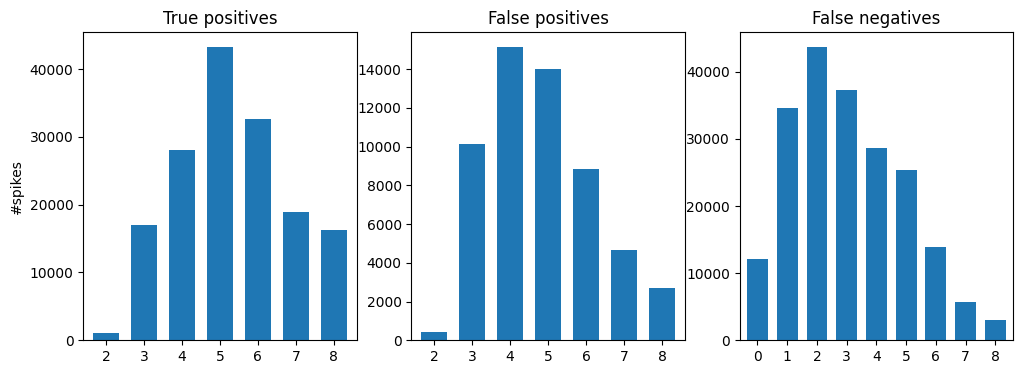

In [107]:
"""
For each metric, plot histograms for all:
    1. True positives (prop_and_ks_units)
    2. False positives (prop_only_units)
    3. False negatives (ks_only_units)
    
metrics: (elec, num_inner_loose_elecs, num_loose_elecs, fraction_loose_elecs, latency_diff, amp_median_diff, score)
"""
metric_idx = 1  # metric index in time_to_spike_match[time]
print("Num. inner loose electrodes")  

fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
              
plot.bar(true_positives, ax=a0)
plot.bar(false_positives, ax=a1)
plot.bar(false_negatives, ax=a2)

a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Num. loose elecs


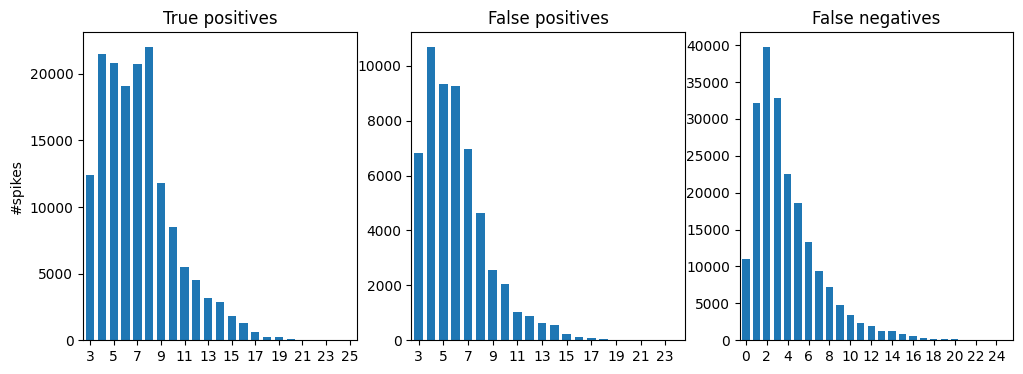

In [108]:
metric_idx = 2 
print(f"Num. loose elecs")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
plot.bar(true_positives, ax=a0)
plot.bar(false_positives, ax=a1)
plot.bar(false_negatives, ax=a2)

for ax in (a0, a1, a2):
    ax.set_xticks(ax.get_xticks()[::2])
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Percent loose elecs


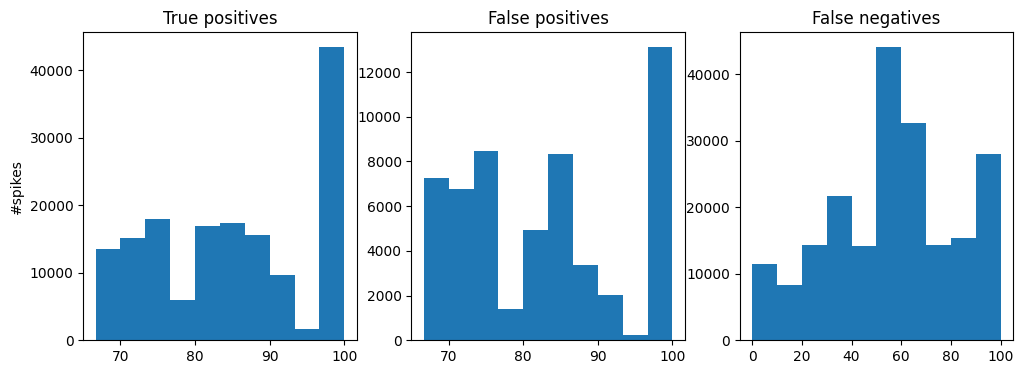

In [112]:
metric_idx = 3
print(f"Percent loose elecs")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
kwargs = {"bins": 10}
plot.hist(np.array(true_positives)*100, axis=a0, **kwargs)
plot.hist(np.array(false_positives)*100, axis=a1, **kwargs)
plot.hist(np.array(false_negatives)*100, axis=a2, **kwargs)

# for ax in (a0, a1):
#     ax.set_xticks(ax.get_xticks()[::2])
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Latency difference


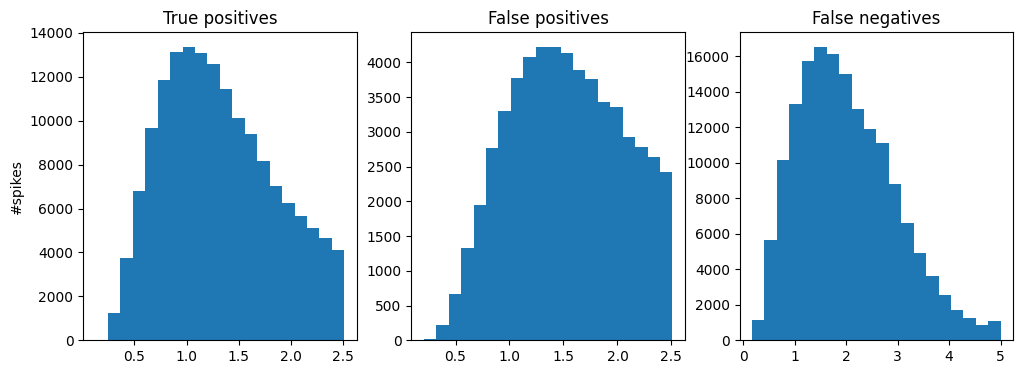

In [113]:
metric_idx = 4
print(f"Latency difference")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
kwargs = {"bins": 20}
plot.hist(true_positives, axis=a0, **kwargs)
plot.hist(false_positives, axis=a1, **kwargs)
plot.hist(false_negatives, axis=a2, **kwargs)
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Amplitude difference


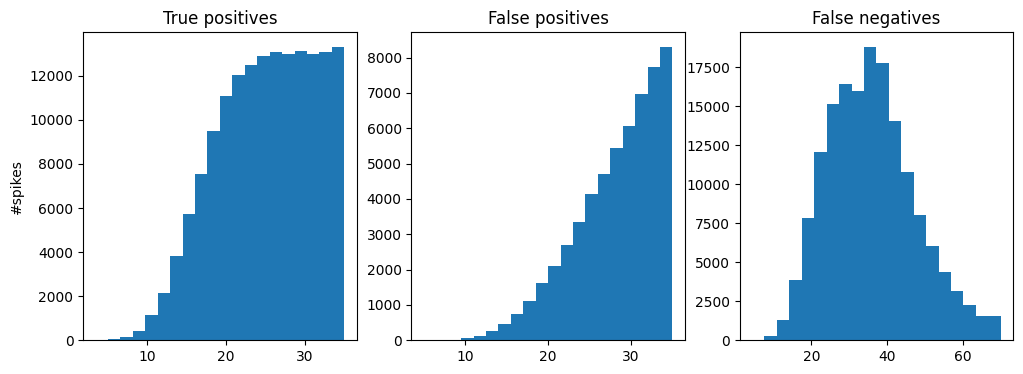

In [114]:
metric_idx = 5
print(f"Amplitude difference")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
kwargs = {"bins": 20}
plot.hist(np.array(true_positives)*100, axis=a0, **kwargs)
plot.hist(np.array(false_positives)*100, axis=a1, **kwargs)
plot.hist(np.array(false_negatives)*100, axis=a2, **kwargs)
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

#### Scatter plots
metrics: (elec, num_inner_loose_elecs, num_loose_elecs, fraction_loose_elecs, latency_diff, amp_median_diff, score)

In [115]:
all_true_positives, all_false_positives, all_false_negatives = F.get_spike_metrics(all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)

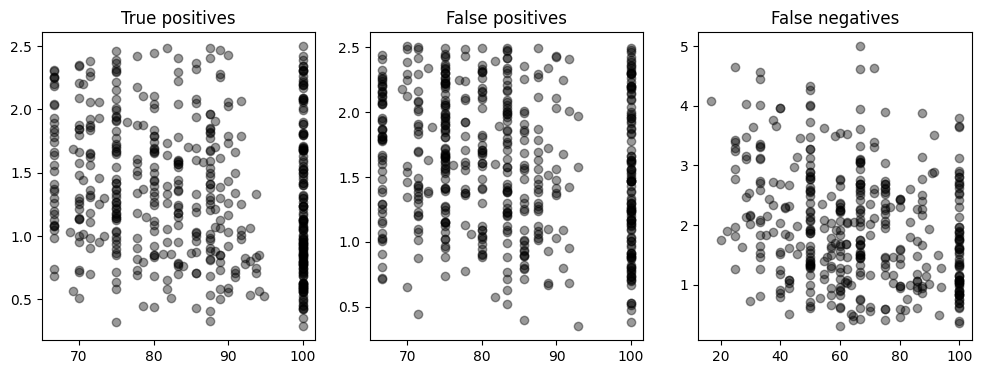

In [116]:
x_metric = 3  # fraction_loose_elecs 
y_metric = 4  # latency_diff

num_spikes = 500  # for each subplot
##
np.random.seed(231)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, spikes in zip(axes, (all_true_positives, all_false_positives, all_false_negatives)):
    for idx in np.random.choice(len(spikes), num_spikes, replace=False):
        metrics = spikes[idx]
        x = metrics[x_metric] * 100  # To make into percent
        y = metrics[y_metric]
        if np.isnan(x) or np.isnan(y):
            continue
        
        ax.scatter(x, y, color="black", alpha=0.4)
      
a0, a1, a2 = axes  
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")
plt.show()

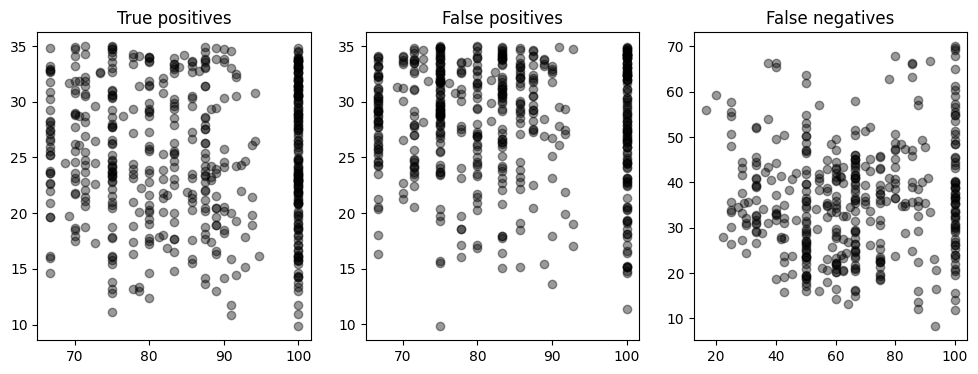

In [117]:
x_metric = 3  # fraction_loose_elecs 
y_metric = 5  # amp_diff

num_spikes = 500  # for each subplot
##
np.random.seed(231)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, spikes in zip(axes, (all_true_positives, all_false_positives, all_false_negatives)):
    for idx in np.random.choice(len(spikes), num_spikes, replace=False):
        metrics = spikes[idx]
        x = metrics[x_metric] * 100  # To make into percent
        y = metrics[y_metric] * 100  # To make into percent
        if np.isnan(x) or np.isnan(y):
            continue
        
        ax.scatter(x, y, color="black", alpha=0.4)
      
a0, a1, a2 = axes  
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")
plt.show()

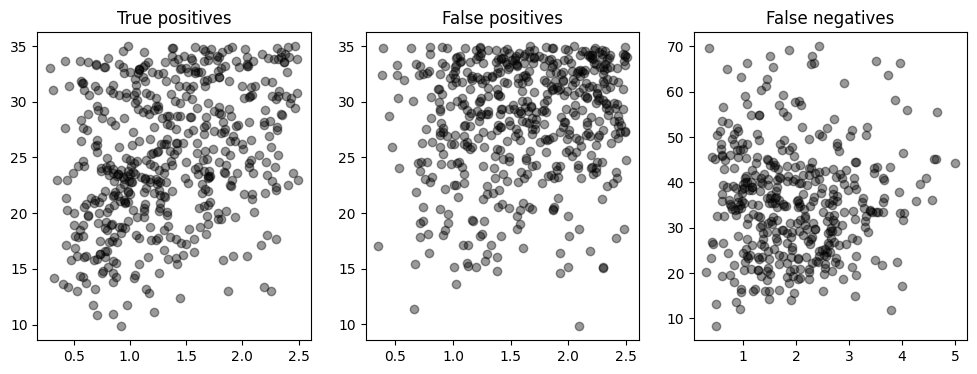

In [118]:
x_metric = 4  # latency_diff 
y_metric = 5  # amp_diff

num_spikes = 500  # for each subplot
##
np.random.seed(231)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, spikes in zip(axes, (all_true_positives, all_false_positives, all_false_negatives)):
    for idx in np.random.choice(len(spikes), num_spikes, replace=False):
        metrics = spikes[idx]
        x = metrics[x_metric] 
        y = metrics[y_metric] * 100  # To make into percent
        if np.isnan(x) or np.isnan(y):
            continue
        
        ax.scatter(x, y, color="black", alpha=0.4)
      
a0, a1, a2 = axes  
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")
plt.show()

#### Precision and recall after each spike assignment threshold

In [94]:
assert False, "This does not work because it does not account for the new false negatives caused by loosening thresholds"

PARAM_TESTS = (
    # (2, 3, 2/3, 2.51, 0.35),
    (-np.inf, -np.inf, -np.inf, np.inf, np.inf),
    # (-np.inf, 3, -np.inf, np.inf, np.inf),
    # (2, 3, -np.inf, np.inf, np.inf),
    # (2, 3, 2/3, np.inf, np.inf),
    # (2, 3, 2/3, 2.51, np.inf),
    # (2, 3, -np.inf, np.inf, 0.35)
    # (2, 3, 2/3, 2.51, 0.35),
    
    # (2, 3, -np.inf, 2.51, 0.35),
    # (2, 3, -np.inf, 4, 0.35), 
    # (2, 3, -np.inf, 2.51, 0.50), 
    # (2, 3, -np.inf, 4, 0.50), 
    # (2, 3, -np.inf, 5, 0.7), 
)
##
all_true_positives, all_false_positives, all_false_negatives = F.get_spike_metrics(all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
for (min_inner_loose_detections, min_loose_detections_n, min_loose_detections_r, max_latency_diff, max_amp_median_diff) in PARAM_TESTS:
    num_tp = num_fp = num_fn = 0
    for elec, num_inner_loose_elecs, num_loose_elecs, ratio_loose_elecs, latency_diff, amp_median_diff, score in all_true_positives:
        if num_inner_loose_elecs >= min_inner_loose_detections and \
            num_loose_elecs >= min_loose_detections_n and \
            ratio_loose_elecs >= min_loose_detections_r and \
            latency_diff <= max_latency_diff and \
            amp_median_diff <= max_amp_median_diff:
            num_tp += 1
        else:
            num_fp += 1
    for elec, num_inner_loose_elecs, num_loose_elecs, ratio_loose_elecs, latency_diff, amp_median_diff, score in all_false_positives:
        if num_inner_loose_elecs >= min_inner_loose_detections and \
            num_loose_elecs >= min_loose_detections_n and \
            ratio_loose_elecs >= min_loose_detections_r and \
            latency_diff <= max_latency_diff and \
            amp_median_diff <= max_amp_median_diff:
            num_fp += 1
    for elec, num_inner_loose_elecs, num_loose_elecs, ratio_loose_elecs, latency_diff, amp_median_diff, score in all_false_negatives:
        if np.isnan(latency_diff):
            num_fn += 1
        elif num_inner_loose_elecs >= min_inner_loose_detections and \
            num_loose_elecs >= min_loose_detections_n and \
            ratio_loose_elecs >= min_loose_detections_r and \
            latency_diff <= max_latency_diff and \
            amp_median_diff <= max_amp_median_diff:
            num_tp += 1
        else:
            num_fn += 1
    
    print(f"{min_inner_loose_detections}_{min_loose_detections_n}_{min_loose_detections_r*100:.0f}%, {max_latency_diff} frames, {max_amp_median_diff}%")
    print(f"Precision: {num_tp / (num_tp+num_fp) *100:.1f}%")
    print(f"Recall: {num_tp / (num_tp + num_fn) *100:.1f}%")
    print()
    
    # Probably because of spike splitting, precision and recall when using correct thresholds are slightly difference

-inf_-inf_-inf%, inf frames, inf%
Precision: 84.9%
Recall: 87.1%



#### Footprints

--------------------------------------------------


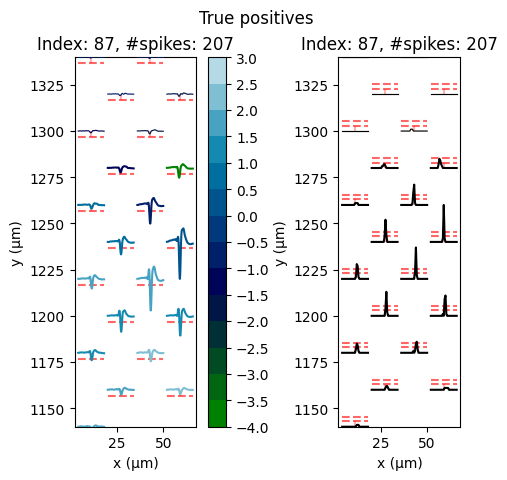

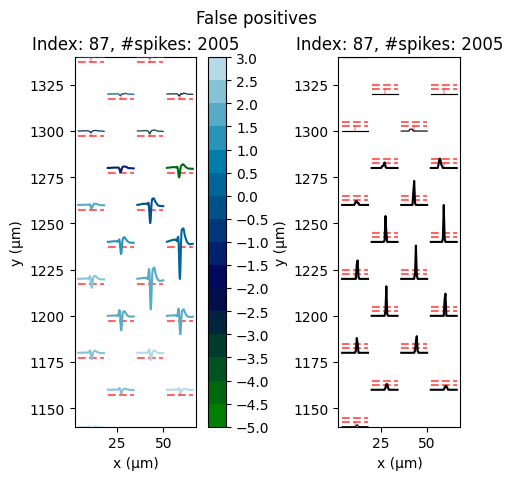

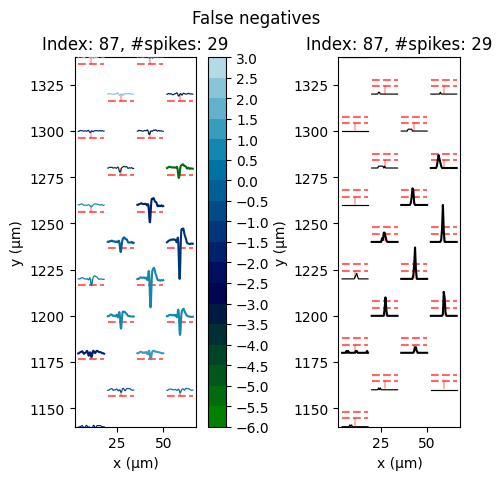

In [ ]:
num_units = 1
##
np.random.seed(231)
ind = np.random.choice(len(prop_and_ks_units), num_units)

# for prop_and_ks, prop_only, ks_only in zip(prop_and_ks_units, prop_only_units, ks_only_units):
for idx in ind:
    prop_and_ks, prop_only, ks_only = prop_and_ks_units[idx], prop_only_units[idx], ks_only_units[idx]
    print("-"*50)
    
    F.plot_elec_probs(prop_and_ks)
    plt.suptitle("True positives")
    plt.show()
    
    F.plot_elec_probs(prop_only)
    plt.suptitle("False positives")
    plt.show()
    
    F.plot_elec_probs(ks_only)
    plt.suptitle("False negatives")
    plt.show()

#### Save footprints

In [122]:
SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230/footprints")

In [123]:
for prop_and_ks, prop_only, ks_only in zip(tqdm(prop_and_ks_units), prop_only_units, ks_only_units):
    # For testing
    # idx = 44
    # prop_and_ks, prop_only, ks_only = prop_and_ks_units[idx], prop_only_units[idx], ks_only_units[idx]

    save_path = SAVE_ROOT / str(prop_and_ks.idx)
    save_path.mkdir(parents=True, exist_ok=True)

    if len(prop_and_ks.spike_train) > 0:
        F.plot_elec_probs(prop_and_ks)
        plt.suptitle("True positives")
        plt.savefig(save_path / "true_positives.jpg", format="jpg")
        plt.close()

    if len(prop_only.spike_train) > 0:
        F.plot_elec_probs(prop_only)
        plt.suptitle("False positives")
        plt.savefig(save_path / "false_positives.jpg", format="jpg")
        plt.close()

    if len(ks_only.spike_train) > 0:
        F.plot_elec_probs(ks_only)
        plt.suptitle("False negatives")
        plt.savefig(save_path / "false_negatives.jpg", format="jpg")
        plt.close()

  0%|          | 0/211 [00:00<?, ?it/s]

100%|██████████| 211/211 [10:46<00:00,  3.06s/it]


### Development

##### 12/29/23 - Why so many spikes missed by RT-Sort?

In [71]:
IDX = 1
OVERLAP_TIME = 0.4

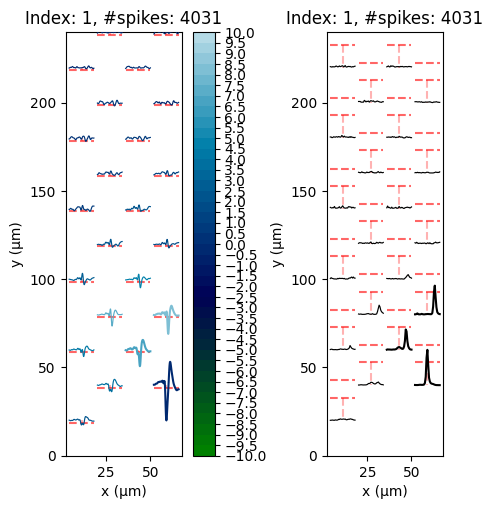

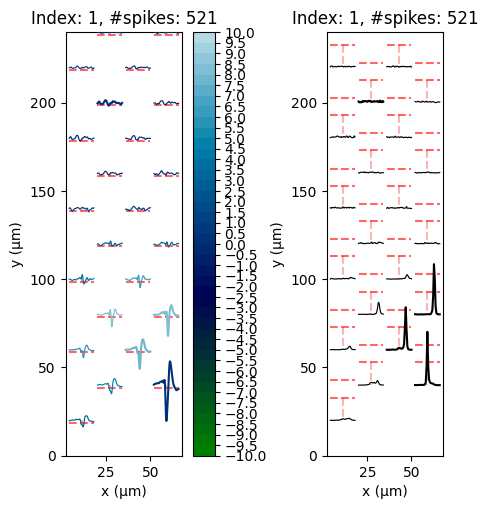

In [72]:
ks_unit = all_ks_units[IDX]
prop_unit = all_prop_units[IDX]
## 
amp_kwargs, prob_kwargs = F.plot_elec_probs(ks_unit)
plt.show()
F.plot_elec_probs(prop_unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.show()

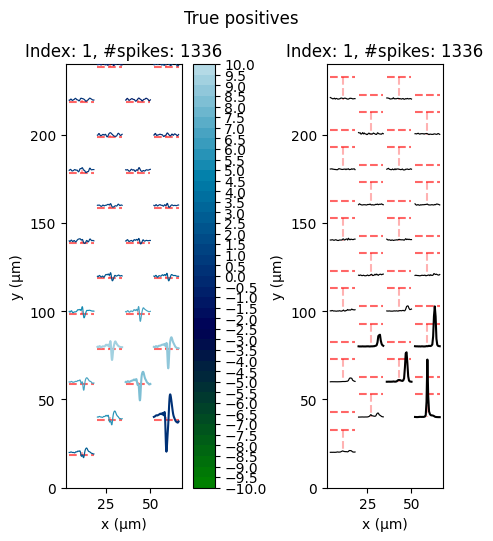

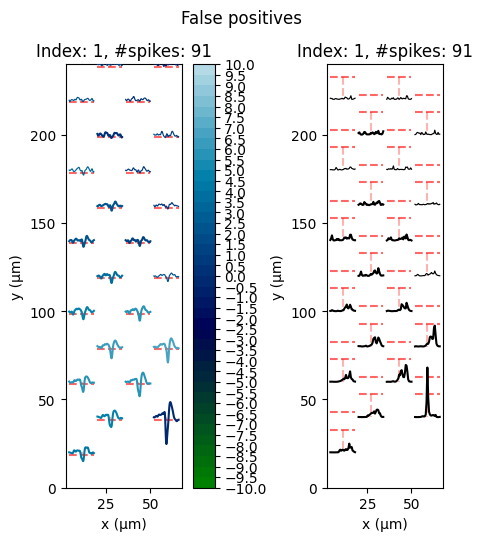

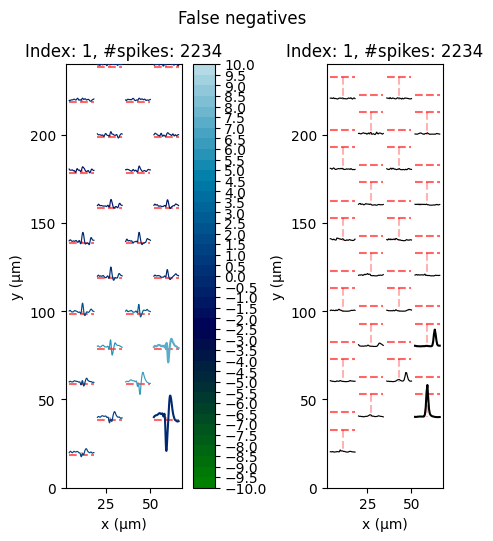

In [20]:
F.plot_elec_probs(prop_and_ks_units[IDX], amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.suptitle("True positives")
plt.show()

F.plot_elec_probs(prop_only_units[IDX], amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.suptitle("False positives")
plt.show()

F.plot_elec_probs(ks_only_units[IDX], amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.suptitle("False negatives")
plt.show()

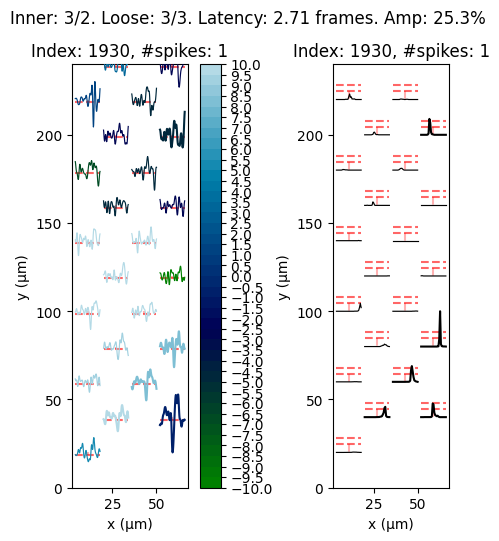

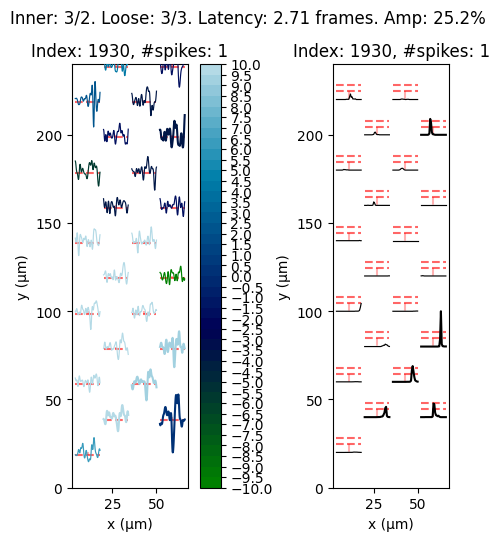

In [136]:
SPIKE_IDX = 1930
##
time = ks_only_units[IDX].spike_train[SPIKE_IDX]
F.plot_seq_spike_overlap(seq, time, SPIKE_IDX)
plt.show()

F.plot_seq_spike_overlap(seq, 207257.033333, SPIKE_IDX)
plt.show()


In [ ]:
F.assign_spikes([deepcopy(seq)], TRAINING_MS,
                interelec=True, only_max_amps=False,
                verbose=True)

In [125]:
test = F.setup_cluster(deepcopy(all_ks_sequences[1]))
test = np.sort(test)
print(np.mean(test))
print(np.mean(test[round(0.2*len(test)):-round(0.2*len(test))]))
print(np.median(test))

0.10014746770508275
0.02079222851897385
0.007289761388122044


In [84]:
all_ks_sequences[1].comp_elecs

[1, 2, 3, 4, 5, 6, 7, 9]

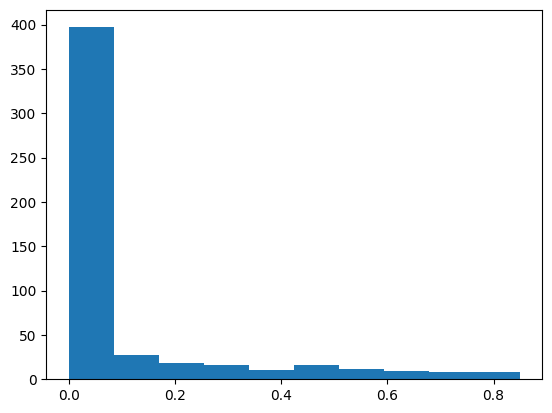

In [81]:
plt.hist(test)
plt.show()

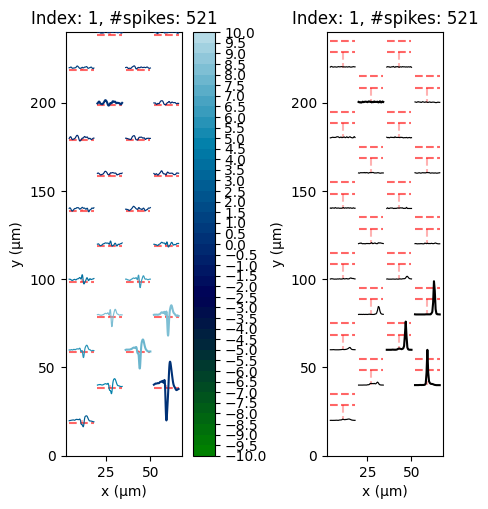

In [93]:
F.plot_elec_probs(seq)
plt.show()

In [106]:
seq.comp_elecs

[1, 2, 3, 4, 5, 6, 7, 9]

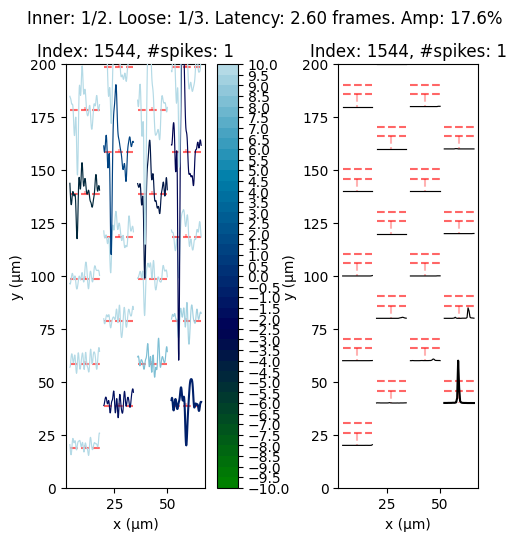

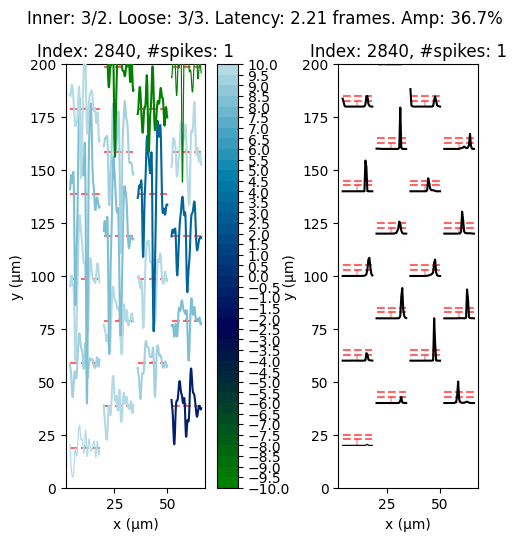

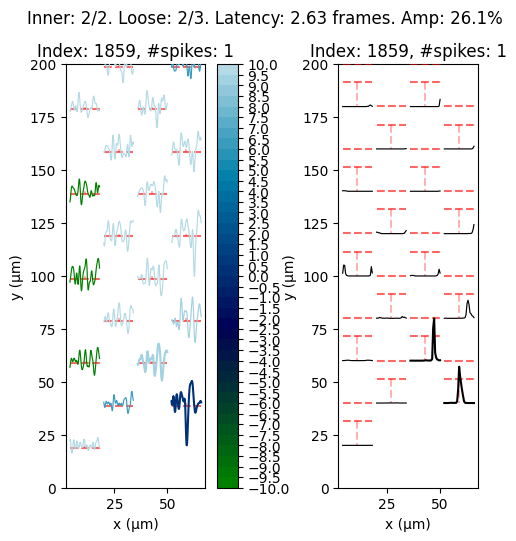

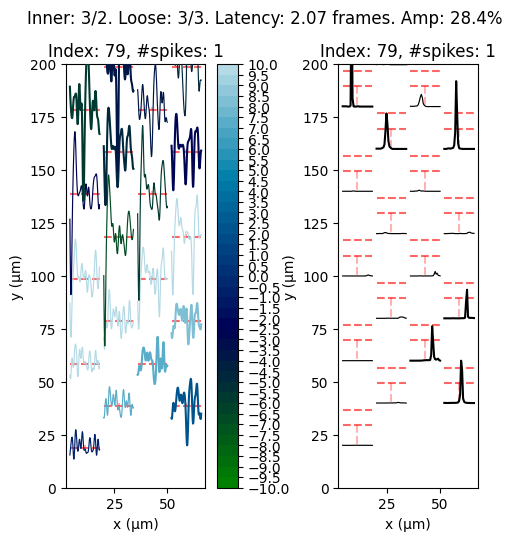

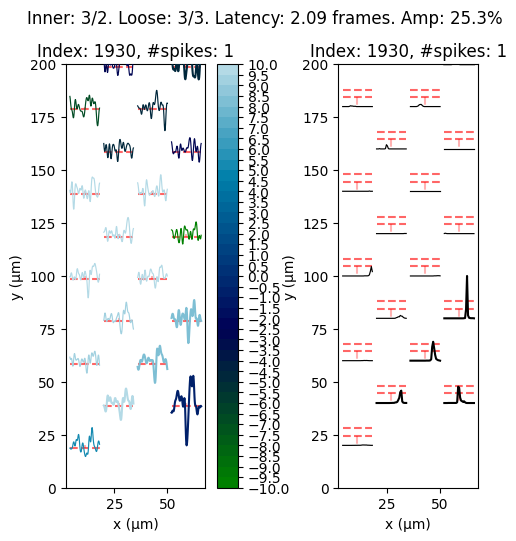

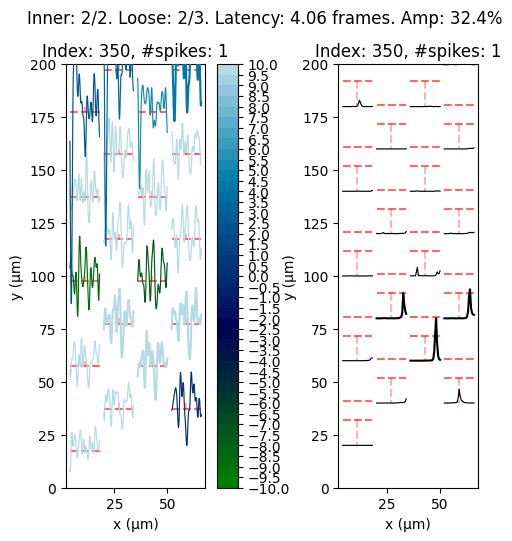

In [ ]:
np.random.seed(100)

seq = all_ks_sequences[IDX]
ks_only = ks_only_units[IDX]

for idx in np.random.choice(len(ks_only.spike_train), 6):
    time = ks_only.spike_train[idx]
    F.plot_seq_spike_overlap(seq, time, idx)
    plt.show()

In [ ]:
seq = all_ks_sequences[IDX]

latency_diffs = []
amp_median_diffs = []
for time in tqdm(ks_only_units[IDX].spike_train):
    latency_diff, amp_median_diff = F.get_seq_spike_overlap(seq, time)
    latency_diffs.append(latency_diff)
    amp_median_diffs.append(amp_median_diff)

100%|██████████| 3336/3336 [00:14<00:00, 229.64it/s]


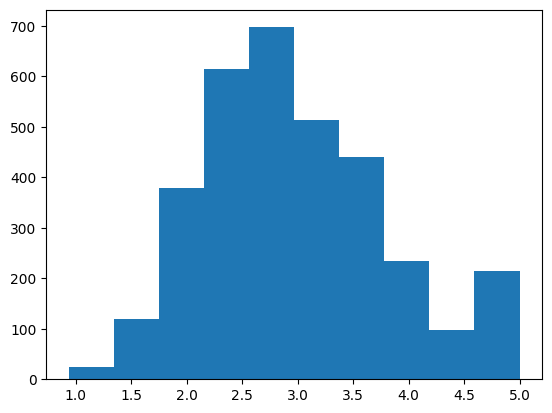

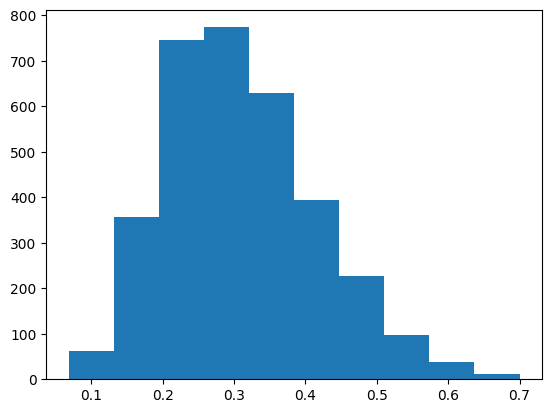

In [ ]:
plt.hist(latency_diffs)
plt.show()
plt.hist(amp_median_diffs)
plt.show()

In [ ]:
sequence = all_ks_sequences[IDX]
count = 0
for spike in ks_unit.spike_train:
    if spike in sequence.time_to_spike_match:
        count += 1
# true_positives, false_positives, false_negatives = Comparison.get_matching_events(ks_unit.spike_train, prop_unit.spike_train)
detectable_times = list(sequence.time_to_spike_match.keys())  # All spikes that can be detected by RT-Sort (detected on at least two elecs by DL model)
detectable_times = np.sort(detectable_times)

# Get ks's closest spike match in time_to_spike_match (upper bound of #matches, i.e. only requirement is DL model detecting on at least two elecs)
max_num_matches = 0  
for ks_spike in ks_unit.spike_train:
    _, prop_spike = utils.find_closest(detectable_times, ks_spike)
    if np.abs(prop_spike - ks_spike) <= OVERLAP_TIME:
        max_num_matches += 1
print(f"Maximum #matches: {max_num_matches}")

Maximum #matches: 2761


In [ ]:
print(f"All stringnet + >=1 loose DL detections:", len(detectable_times))

All stringnet + >=1 loose DL detections: 10829


## Ground-truth units as sequences
Get ground truth units as sequences to test and tune real-time spike assignment

In [11]:
ROOT_PATH = Path("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/240331_ground_truth_as_sequences")
ROOT_PATH.mkdir(exist_ok=True, parents=True)

In [12]:
from spikeinterface.extractors import NwbSortingExtractor
sorter = NwbSortingExtractor("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/sub-MEAREC-250neuron-Neuropixels_ecephys.nwb")
ground_truth_spike_trains = [sorter.get_unit_spike_train(uid) / sorter.get_sampling_frequency() * 1000 for uid in sorter.get_unit_ids()]

In [13]:
# Setup units as sequences --> need to find root elec (max-amp elec)

all_sequences = []
chan_to_ks_seqs = {}

def job(idx):    
    spike_train = ground_truth_spike_trains[idx]
    spike_train = spike_train[spike_train <= TRAINING_MS[1]]
    cluster = F.CocCluster(-1, -1, spike_train)
    
    all_waveforms = F.extract_waveforms(cluster)   
    templates = np.mean(all_waveforms, axis=0)
    root_elec = np.argmin(np.min(templates, axis=1))
    
    cluster.root_elec = root_elec
    cluster.root_elecs = [root_elec]
    cluster.split_elecs = [root_elec] + [elec for elec in ALL_CLOSEST_ELECS[root_elec] if F.calc_elec_dist(elec, root_elec) <= F.INNER_RADIUS]
    
    # Need to align ground-truth spike times with peak 
    np.random.seed(231)
    n_before=10  # Needs to be small since many spikes occur at about the same time
    n_after=10  # Needs to be small since many spikes occur at about the same time
    
    spike_train = np.random.choice(spike_train, 300)
    corrected_spike_train = []
    for spike in spike_train:
        frame = F.rec_ms_to_output_frame(spike)
        this_n_before = n_before if frame - n_before >= 0 else frame
        outputs = F.OUTPUTS[root_elec, frame-this_n_before:frame+n_after]
        spike_offset = np.argmax(outputs) - this_n_before
        corrected_spike_train.append((frame+spike_offset+F.FRONT_BUFFER)/SAMP_FREQ)
    cluster._spike_train = np.array(corrected_spike_train)
    
    F.setup_cluster(cluster, n_cocs=300)
    
    return cluster

with Pool(processes=20) as pool:
    tasks = range(len(ground_truth_spike_trains))
    for idx, cluster in tqdm(enumerate(pool.imap(job, tasks)), total=len(tasks)):
        cluster.idx = idx
        all_sequences.append(cluster)
for seq in chan_to_ks_seqs:
    if seq.root_elec not in chan_to_ks_seqs:
        chan_to_ks_seqs[seq.root_elec] = [seq]
    else:
        chan_to_ks_seqs[seq.root_elec].append(seq)
utils.pickle_dump(all_sequences, ROOT_PATH / "all_sequences")

# # Testing
# SEQ = job(6)
# F.plot_elec_probs(SEQ)
# plt.show()
# for elec in SEQ.loose_elecs:
#     print(ELEC_LOCS[elec], SEQ.all_latencies[elec])

# # Old testing (still used "ks" in name)
# # Plot example
# cluster = original_ks_sequences[1]
# F.plot_elec_probs(cluster)
# plt.show()
# print(cluster.comp_elecs)
# print(cluster.all_latencies[cluster.comp_elecs])
# print(cluster.all_amp_medians[cluster.comp_elecs])

# cluster = original_ks_sequences[49]
# F.plot_elec_probs(cluster)
# plt.show()
# print(cluster.comp_elecs)
# print(cluster.all_latencies[cluster.comp_elecs])
# print(cluster.all_amp_medians[cluster.comp_elecs])

100%|██████████| 250/250 [01:40<00:00,  2.48it/s]


In [ ]:
# # Plot some sequences
# np.random.seed(231)
# for cluster in np.random.choice(all_sequences, 2, replace=False):
#     F.plot_elec_probs(cluster)
#     plt.show()

In [14]:
all_sequences = utils.pickle_load(ROOT_PATH / "all_sequences")

In [15]:
filtered_sequences = F.filter_clusters(all_sequences)
utils.pickle_dump(filtered_sequences, ROOT_PATH / "filtered_sequences")

In [16]:
filtered_sequences = utils.pickle_load(ROOT_PATH / "filtered_sequences")

In [17]:
F.assign_spikes_torch(filtered_sequences, TESTING_MS)
torch.cuda.empty_cache()
utils.pickle_dump(filtered_sequences, ROOT_PATH / "tested_sequences")
tested_sequences = utils.pickle_load(ROOT_PATH / "tested_sequences")

100%|██████████| 59990/59990 [01:57<00:00, 509.89it/s]


In [18]:
tested_sequences = utils.pickle_load(ROOT_PATH / "tested_sequences")

In [ ]:
# Go up to section "Compare to ground truth" to measure performance

### Testing

  0%|          | 0/59990 [00:00<?, ?it/s]

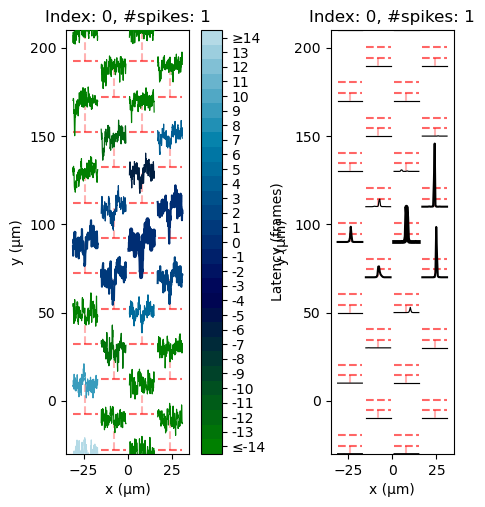

100%|██████████| 59990/59990 [00:36<00:00, 1631.30it/s]


In [168]:
test = F.assign_spikes_torch([rt], TESTING_MS, return_spikes=True)
rt._spike_train = test[0]

  0%|          | 0/1393 [00:00<?, ?it/s]

100%|██████████| 1393/1393 [00:00<00:00, 39236.22it/s]


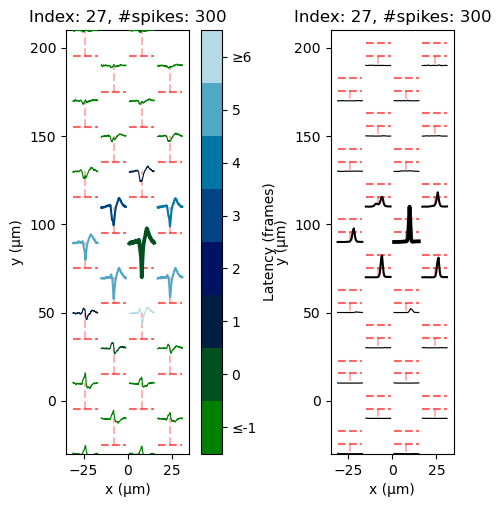

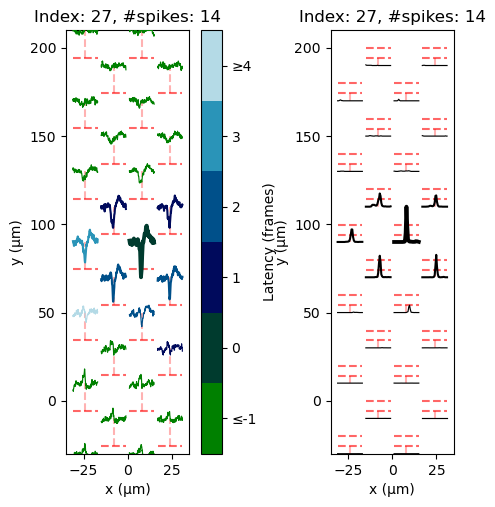

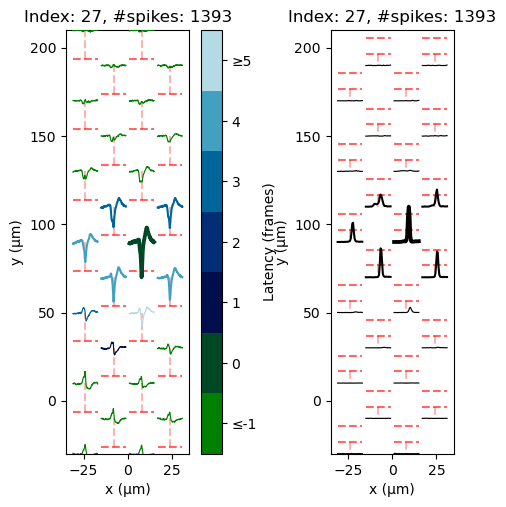

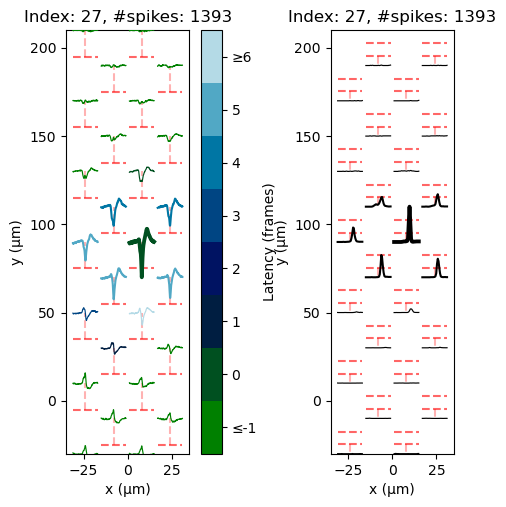

In [155]:
# Plot 1) ground-truth unit in TRAINING_MS 2) RT-Sort spikes in TESTING_MS 3) ground-truth spikes in TESTING_MS
SEQ_IDX = 9

n_before=n_after=6
##
rt = tested_sequences[SEQ_IDX]
gt_spikes = ground_truth_spike_trains[rt.idx]
gt_spikes = gt_spikes[(gt_spikes >= TESTING_MS[0]) & (gt_spikes <= TESTING_MS[1])]
gt_corrected = []
for spike in tqdm(gt_spikes):
    frame = round(spike * SAMP_FREQ)
    this_n_before = n_before if frame - n_before >= 0 else frame
    trace = F.TRACES[rt.root_elec, frame-this_n_before:frame+n_after]
    spike_offset = np.argmin(trace) - this_n_before
    gt_corrected.append((frame+spike_offset)/SAMP_FREQ)

F.plot_elec_probs(all_sequences[rt.idx])

F.plot_elec_probs(rt)
plt.show()

F.plot_spikes(gt_spikes, rt.root_elec, idx=rt.idx)
plt.show()

F.plot_spikes(gt_corrected, rt.root_elec, idx=rt.idx)
plt.show()

In [ ]:
F.plot_spikes([gt_corrected[8]], rt.root_elec)
plt.show()

In [156]:
from src.comparison import Comparison
matching, rt_only, gt_only = Comparison.get_matching_events(rt.spike_train, gt_corrected)

In [134]:
for elec in rt.loose_elecs:
    print(ELEC_LOCS[elec], rt.all_latencies[elec])

[-24.  90.] 4.566666666666666
[-8. 70.] 4.56
[ -8. 110.] 2.97
[24. 70.] 4.3566666666666665
[ 24. 110.] 3.5533333333333332


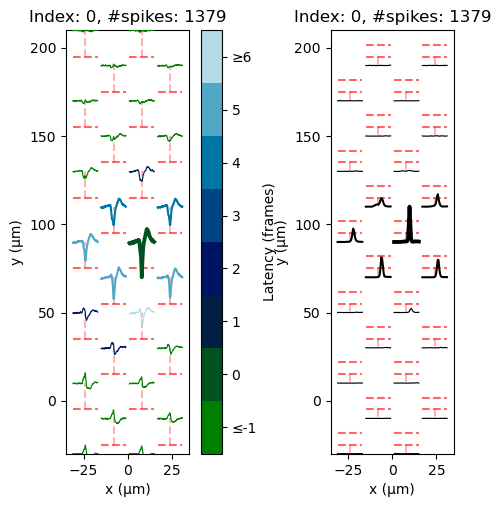

In [137]:
F.plot_spikes(gt_only, rt.root_elec)
plt.show()

In [139]:
gt_only_cluster = deepcopy(rt)
gt_only_cluster._spike_train = gt_only
F.setup_cluster(gt_only_cluster)

302286.21875


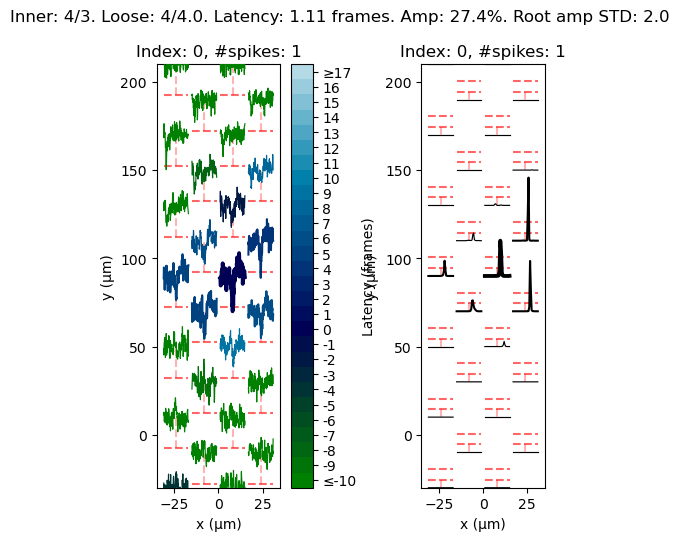

In [158]:
print(gt_only[7])
F.plot_seq_spike_overlap(rt, gt_only[7])
plt.show()

## Consistent spikes
Save footprints of matching, RT-Sort only spikes, other sorter spikes using data from consistent_spikes.ipynb

In [89]:
ROOT_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240203/consistent_spikes_si_formula")
SORTER_PATHS = [
    ROOT_PATH / "kilosort2.npy",
    ROOT_PATH / "herdingspikes.npy",
    ROOT_PATH / "ironclust.npy",
    ROOT_PATH / "tridesclous.npy",
    ROOT_PATH / "spykingcircus.npy",
    ROOT_PATH / "hdsort.npy"
]
SORTER_NAMES = [  # Used in plots
    "Kilosort2",
    "HerdingSpikes2",
    "IronClust",
    "Tridesclous",
    "SpyKING Circus",
    "HDSort"
]
SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240203/consistent_spikes_si_formula/footprints")

In [113]:
def job(task):
    """
    Testing 
    
    kilosort = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240203/consistent_spikes_si_formula/kilosort2.npy", allow_pickle=True)
    unit_idx = [unit["idx"] for unit in kilosort].index(0)
    
    SORTER = np.load(SORTER_PATHS[0], allow_pickle=True)
    SORTER_NAME = "Kilosort2"
    job((2, None))
    
    m = matching
    r = RT-Sort
    o = other
    """
    assert False, "Make updates"
    """
    Updates 
    
    Some comments that came from the MEA meeting that are relevant for you is that it would be nice to mark the root electrode in the footprint figures (for example by making the line even thicker). Furthermore, for the figure with the footprints for the three spike groups (matched, RT-Sort only and other sorter only), it would be nice if in all cases the loose electrodes of the sequence have thick lines, not just the electrodes that have detections above the loose threshold for that subset of spikes.
    """
    
    unit_idx, save_dir = task
    sorter=SORTER
    sorter_name=SORTER_NAME

    chans_rms = np.full(NUM_ELECS, 1)
    unit_data = sorter[unit_idx]

    fig, axes = plt.subplots(ncols=3, figsize=(2.3*3, 5.5))
    m_ax, r_ax, o_ax = axes

    m_unit=Unit(unit_data['idx'], [spike['time'] for spike in unit_data['matching_spikes']], unit_data["root_elec"], RECORDING)
    m_temps, m_wf_widths, m_wf_colors = F.plot_elec_probs(m_unit, return_wf_data=True)
    r_unit=Unit(unit_data['idx'], [spike['time'] for spike in unit_data['rt_sort_only_spikes']], unit_data["root_elec"], RECORDING)
    r_temps, r_wf_widths, r_wf_colors = F.plot_elec_probs(r_unit, return_wf_data=True)
    o_unit=Unit(unit_data['idx'], [spike['time'] for spike in unit_data['other_sorter_only_spikes']], unit_data["root_elec"], RECORDING)
    o_temps, o_wf_widths, o_wf_colors = F.plot_elec_probs(o_unit, return_wf_data=True)
    
    # Determine color bar limits
    color_elecs = unit_data['loose_elecs']  # Elecs used to determine color bar limits
    min_c = np.inf
    max_c = -np.inf
    for colors in (m_wf_colors, r_wf_colors, o_wf_colors):
        if np.all(np.isnan(colors)):
            continue
        colors = [colors[elec] for elec in color_elecs]
        min_c = min(min_c, round(np.floor(np.min(colors))) - 1)
        max_c = max(max_c, round(np.ceil(np.max(colors))) + 1)
    
    amp_kwargs = m_unit.plot(axis=m_ax, wf=m_temps, wf_widths=m_wf_widths, wf_colors=m_wf_colors, fig=fig, mea=False,
                             chans_rms=chans_rms, min_c=min_c, max_c=max_c)
    r_unit.plot(axis=r_ax, wf=r_temps, wf_widths=r_wf_widths, wf_colors=r_wf_colors, fig=None, mea=False,
                **amp_kwargs)
    o_unit.plot(axis=o_ax, wf=o_temps, wf_widths=o_wf_widths, wf_colors=o_wf_colors, fig=None, mea=False,
                **amp_kwargs)

    m_ax.set_title("Matching")
    r_ax.set_title("RT-Sort only")
    o_ax.set_title(f"{sorter_name} only")
    
    for ax in axes:
        ax.set_xlabel("")
        ax.set_xticks([])
        ax.set_ylabel("")
        ax.set_yticks([])

    # plt.show()
    plt.savefig(save_dir / f"{unit_data['idx']}.jpg", format="jpg")
    plt.close()
    
np.seterr("ignore")  # RuntimeWarning: invalid value encountered in true_divide ret, rcount, out=ret, casting='unsafe', subok=False) # Mean of empty slice warning is when matching, RT-Sort only, or other only have no spikes
for sorter_path, SORTER_NAME in zip(SORTER_PATHS, SORTER_NAMES):
    print(SORTER_NAME)
    SORTER = np.load(sorter_path, allow_pickle=True)
    save_dir = SAVE_ROOT / sorter_path.name.split(".")[0]
    save_dir.mkdir(parents=True, exist_ok=True)
    tasks = [(unit_idx, save_dir) for unit_idx in range(len(SORTER))]
    with Pool(processes=16) as pool:
        for _ in tqdm(pool.imap_unordered(job, tasks), total=len(tasks)):
            pass
np.seterr('raise')

Kilosort2


  0%|          | 0/216 [00:00<?, ?it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 34%|███▍      | 73/216 [00:32<00:44,  3.23it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 35%|███▍      | 75/216 [00:33<01:01,  2.29it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 75%|███████▌  | 162/216 [01:01<00:13,  4.09it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 216/216 [01:21<00:00,  2.64it/s]


HerdingSpikes2


  0%|          | 1/216 [00:02<09:03,  2.53s/it]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 33%|███▎      | 71/216 [00:30<01:00,  2.38it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 35%|███▌      | 76/216 [00:31<00:31,  4.44it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 216/216 [01:13<00:00,  2.95it/s]


IronClust


  0%|          | 0/216 [00:00<?, ?it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
  3%|▎         | 6/216 [00:07<03:00,  1.17it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 22%|██▏       | 48/216 [00:23<00:38,  4.35it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 33%|███▎      | 72/216 [00:31<00:39,  3.61it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 35%|███▍      | 75/216 [00:33<01:13,  1.93it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 37%|███▋ 

Tridesclous


  2%|▏         | 5/216 [00:07<03:41,  1.05s/it]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 20%|██        | 44/216 [00:23<01:08,  2.53it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 31%|███       | 66/216 [00:30<00:40,  3.73it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 34%|███▍      | 74/216 [00:33<00:45,  3.10it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 73%|███████▎  | 157/216 [01:02<00:22,  2.65it/s]

SpyKING Circus


  1%|▏         | 3/216 [00:05<05:40,  1.60s/it]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 35%|███▌      | 76/216 [00:33<00:52,  2.65it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 36%|███▌      | 78/216 [00:34<00:49,  2.79it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 75%|███████▌  | 162/216 [01:01<00:14,  3.67it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 90%|████████▉ | 194/216 [01:14<00:10,  2.16it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

HDSort


  0%|          | 1/216 [00:02<08:10,  2.28s/it]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 33%|███▎      | 71/216 [00:33<01:00,  2.39it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 216/216 [01:23<00:00,  2.57it/s]


{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [ ]:
# Sanity check, compare means of spikes with footprints
# means = np.array([spike['elecs'] for spike in unit_data['other_sorter_only_spikes']])
# means = np.mean(means, axis=0)
# print(means[:5])